In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
import gurobipy as gp
from gurobipy import GRB

options = {
    "WLSACCESSID": "31598bc4-0b23-474f-86d4-af032d437137",
    "WLSSECRET": "bd7ad348-f8d6-452e-b615-ebc88d920e41",
    "LICENSEID": 2498404,
}

In [3]:
import os
import re

tickerList = ['AMZN', 'GOOGL', 'JNJ', 'JPM', 'MSFT', 'PG', 'TSLA', 'V', 'WMT']

In [4]:
data_path = f'data/paired_Option'
data_files = os.listdir(data_path)
# print(sorted(data_files))

In [5]:
pattern = r'^([A-Z]+)_(\d{8})_(\d{8})\.csv$'

In [6]:
N = 20

In [7]:
def payoff(S1,S2):
    return max(S2 - S1, 0)

In [8]:
stocks = pd.read_csv('adjusted_stocks.csv')
stocks.head()

,Date,AMZN,JPM,JNJ,MSFT,PG,WMT,GOOGL,V,TSLA
0,2018-01-02,1189.010010,90.125488,117.502670,80.080925,76.669670,88.322428,1073.209991,109.733635,320.530014
1,2018-01-03,1204.199982,90.217331,118.625122,80.453613,76.576607,89.092855,1091.520004,110.826103,317.249994
2,2018-01-04,1209.589996,91.509758,118.616730,81.161705,77.117928,89.173491,1095.759964,111.238144,314.619999
3,2018-01-05,1229.140015,90.922310,119.595680,82.167976,77.168678,89.702036,1110.289993,113.902199,316.580000
4,2018-01-08,1246.869965,91.056587,119.747589,82.251801,77.574646,91.027891,1114.209976,114.362175,336.410007


In [10]:
def params(df_t0, N):    
    C1 = df_t0['C1']
    C2 = df_t0['C2']
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    S0 = df_t0['Adj_S0'].unique()
    # Adjustment of I_ref
    I_ref = 50
    d_S1, u_S1 = min(K1)-I_ref, max(K1)+I_ref
    d_S2, u_S2 = min(K2)-I_ref, max(K2)+I_ref
    while realS1 > u_S1:
        u_S1 += I_ref
    while realS1 < d_S1:
        d_S1 -= I_ref
    while realS2 > u_S2:
        u_S2 += I_ref
    while realS2 < d_S2:
        d_S2 -= I_ref
    S1 = np.linspace(d_S1, u_S1, N)
    S2 = np.linspace(d_S2, u_S2, N)
    
    m = gp.Model("Price Bounds")
    d = m.addVars(['d'], name="d")
    lamb1 = m.addVars(df_t0.index, name="lamb1")
    lamb2 = m.addVars(df_t0.index, name="lamb2")
    delta0 = m.addVars(['delta0'], name="delta0")
    delta1 = m.addVars(np.array(S1).flatten(), name="delta1")
    
    m.setObjective(d['d'] + 
                   sum(lamb1[r]*C1[r] for r in df_t0.index) + 
                   sum(lamb2[r]*C2[r] for r in df_t0.dropna().index))
        # in our cases the number of options at maturity T2 is less or equal to that at maturity T1
        # thus apply dropna() on T2 exclusively to shorten the running time effectively
    m.ModelSense = GRB.MINIMIZE
    
    for S1_i in S1:
        for S2_j in S2:
            m.addConstr(d['d'] + 
                        sum(lamb1[r]*max(S1_i-K1[r],0) for r in df_t0.index) + 
                        sum(lamb2[r]*max(S2_j-K2[r],0) for r in df_t0.dropna().index) + 
                        delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)
                        >= payoff(S1_i, S2_j), 'C_{}{}'.format(S1_i, S2_j))
            m.update()
    
    m.optimize()
    
    if m.status == GRB.OPTIMAL:
        var = {v.varName: v.x for v in m.getVars()}
        
        delta1_values = np.array([var['delta1[{}]'.format(s1)] for s1 in S1])
        delta1_interpolator = CubicSpline(S1, delta1_values)
        
        parameters = {
            'd': var['d[d]'],
            'lamb1': {r: var['lamb1[{}]'.format(r)] for r in df_t0.index},
            'lamb2': {r: var['lamb2[{}]'.format(r)] for r in df_t0.dropna().index},
            'delta0': var['delta0[delta0]'],
            'delta1': delta1_interpolator
        }
    else:
        print("Optimization was not successful.")
        
    return parameters

In [11]:
def hedgingStrategy(parameters, df_t0):
    S0 = df_t0['Adj_S0'].unique()
    K1 = df_t0['K1']
    K2 = df_t0['K2']
    h = (parameters['d']
         + sum(parameters['lamb1'][r] * max(realS1-K1[r],0) for r in df_t0.index)
         + sum(parameters['lamb2'][r] * max(realS2-K2[r],0) for r in df_t0.dropna().index)
         + parameters['delta0'] * (realS1 - S0)
         + parameters['delta1'](realS1) * (realS2-realS1)
        )
    return h

In [12]:
%%time
df_gap_S0 = pd.DataFrame()
df_gap_hedge = pd.DataFrame()

for filename in sorted(data_files):
    match = re.match(pattern, filename)
    ticker = match.group(1)
    date1 = match.group(2)
    date2 = match.group(3)
    t1 = f'{date1[:4]}-{date1[4:6]}-{date1[6:]}'
    t2 = f'{date2[:4]}-{date2[4:6]}-{date2[6:]}'

    path = data_path + '/' + filename
    df = pd.read_csv(path, index_col=0)
    t0List = list(df.t0.unique())
    
    realS1 = stocks.loc[stocks.Date==t1, ticker].item()
    realS2 = stocks.loc[stocks.Date==t2, ticker].item()
    
    gapList_S0 = []
    gapList_hedge = []
    for t0 in t0List:
        df_t0 = df.loc[df.t0 == t0].copy()
        
        parameters = params(df_t0, N)
        h = hedgingStrategy(parameters, df_t0)
        
        S0 = df_t0['Adj_S0'].unique()
        gap_S0 = (h - payoff(realS1, realS2)) / S0
        gap_hedge = (h - payoff(realS1, realS2)) / h
        
        gapList_S0.append(gap_S0.item())
        gapList_hedge.append(gap_hedge.item())

    distance_to_t1 = np.busday_count(pd.to_datetime(t0List).values.astype('datetime64[D]'), 
                                     pd.to_datetime([t1]).values.astype('datetime64[D]'))
    tmp_S0 = pd.DataFrame(np.array(gapList_S0), columns=[filename[:-4]], index=distance_to_t1)
    tmp_hedge = pd.DataFrame(np.array(gapList_hedge), columns=[filename[:-4]], index=distance_to_t1)
    df_gap_S0 = pd.concat([df_gap_S0, tmp_S0.T])
    df_gap_hedge = pd.concat([df_gap_hedge, tmp_hedge.T])

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10340 nonzeros
Model fingerprint: 0x0674794c
Coefficient statistics:
  Matrix range     [3e-01, 5e+02]
  Objective range  [4e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.00s
Presolved: 320 rows, 57 columns, 7748 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.289441e+03   0.000000e+00      0s
      28    8.7735581e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.773558102e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple

  Matrix range     [5e-01, 6e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 6e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10480 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.514194e+03   0.000000e+00      0s
      70    6.6413704e+01   0.000000e+00   0.000000e+00      0s

Solved in 70 iterations and 0.00 seconds (0.01 work units)
Optimal objective  6.641370410e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9380 nonzeros
Model fingerprint: 0xae44c500
Coefficient statistics:
  Matrix range     [1e-01, 4e+02]
  Objective range  [5e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9380 nonzeros

Itera

Model fingerprint: 0x005a1e1f
Coefficient statistics:
  Matrix range     [3e-01, 5e+02]
  Objective range  [6e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9420 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.745099e+03   0.000000e+00      0s
      24    7.1800000e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.180000000e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10480 nonzeros
Model fingerprint: 0xb6da50bc
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve time: 0.00s

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 9e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10620 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.667426e+03   0.000000e+00      0s
      49    7.1309317e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.00 seconds (0.01 work units)
Optimal objective  7.130931743e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10479 nonzeros
Model fingerprint: 0x6398c238
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 6e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.00s
Presolved: 359 rows, 60 columns, 9835 nonzeros

Iteration    Objective       Prim

Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9400 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.927961e+03   0.000000e+00      0s
      35    1.7297238e+02   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.729723835e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9459 nonzeros
Model fingerprint: 0x543bf37d
Coefficient statistics:
  Matrix range     [5e-01, 8e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 8e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 9445 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.639408e+03


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.865707e+03   0.000000e+00      0s
      32    1.0303952e+02   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.030395225e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11500 nonzeros
Model fingerprint: 0xc7a270ec
Coefficient statistics:
  Matrix range     [5e-01, 8e+02]
  Objective range  [8e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 7e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 11500 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.124424e+03   0.000000e+00      0s
      30    1.1467758e+02   0.000000e+00   0.000000e+00      0s

Solved in 30 it


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.817763e+03   0.000000e+00      0s
      14    6.5111375e+01   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds (0.01 work units)
Optimal objective  6.511137462e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11040 nonzeros
Model fingerprint: 0x1053ee77
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 5e+02]
Presolve removed 220 rows and 14 columns
Presolve time: 0.00s
Presolved: 180 rows, 48 columns, 4207 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.929934e+02   0.000000e+00      0s
      12    1.2950000e+02   0.000000e+00

Coefficient statistics:
  Matrix range     [3e-01, 7e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 7e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 11700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.241332e+03   0.000000e+00      0s
      48    7.0727011e+01   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.01 work units)
Optimal objective  7.072701066e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11640 nonzeros
Model fingerprint: 0xad313f73
Coefficient statistics:
  Matrix range     [5e-01, 6e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 colu

Optimal objective  1.000000000e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8620 nonzeros
Model fingerprint: 0x31136998
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 7e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 300 rows and 28 columns
Presolve time: 0.00s
Presolved: 100 rows, 34 columns, 1140 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.750000e+01   0.000000e+00      0s
       4    1.5061728e+02   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.506172840e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores,

  RHS range        [3e+00, 3e+02]
Presolve removed 240 rows and 22 columns
Presolve time: 0.02s
Presolved: 160 rows, 40 columns, 2068 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.379276e+02   0.000000e+00      0s
       8    1.0992382e+02   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.099238227e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 6759 nonzeros
Model fingerprint: 0xe2c6fd57
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [1e+00, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 5e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 6176 nonzeros

Iteration    Objective       

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9359 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.031579e+03   0.000000e+00      0s
      18    7.9042481e+01   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.904248142e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9520 nonzeros
Model fingerprint: 0x3c6b697b
Coefficient statistics:
  Matrix range     [5e-13, 6e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-13, 4e+

Model fingerprint: 0x059beb71
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [5e-03, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 6e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.891711e+03   0.000000e+00      0s
      29    1.3494174e+02   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.349417431e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9139 nonzeros
Model fingerprint: 0xd10ad278
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+02]
Presolve removed 341 

Model fingerprint: 0xf75fcf7a
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [4e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+03]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 13219 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.006878e+04   0.000000e+00      0s
      59    5.4402065e+01   0.000000e+00   0.000000e+00      0s

Solved in 59 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.440206529e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 12739 nonzeros
Model fingerprint: 0x111eb65d
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [7e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range   


Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.538894130e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 12019 nonzeros
Model fingerprint: 0xf5eb7cb3
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [6e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 8e+02]
Presolve removed 181 rows and 12 columns
Presolve time: 0.00s
Presolved: 219 rows, 50 columns, 6201 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.482648e+03   0.000000e+00      0s
      20    5.4254631e+01   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.425463069e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+03]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10199 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.068586e+03   0.000000e+00      0s
      48    1.8908209e+02   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.890820928e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 13160 nonzeros
Model fingerprint: 0x250be534
Coefficient statistics:
  Matrix range     [3e-01, 2e+03]
  Objective range  [6e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+03]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 13160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       

Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7713 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.932928e+03   0.000000e+00      0s
      39    2.3303492e+02   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.330349230e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 6560 nonzeros
Model fingerprint: 0x0bc2d0c5
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 40 rows and 3 columns
Presolve time: 0.00s
Presolved: 360 rows, 59 columns, 6124 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time



Solved in 64 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.294513875e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9980 nonzeros
Model fingerprint: 0x3b3270fa
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-01, 7e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9980 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.459030e+03   0.000000e+00      0s
      38    1.6876700e+02   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.687670000e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread coun


Solved in 40 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.707655106e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9640 nonzeros
Model fingerprint: 0xea32b0e4
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [6e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9371 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.664921e+03   0.000000e+00      0s
      34    1.7869773e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.786977263e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 


Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.770396282e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9399 nonzeros
Model fingerprint: 0x851f03da
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8458 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.678408e+03   0.000000e+00      0s
      34    1.6383549e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.638354872e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored

      45    3.4661933e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.466193252e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9460 nonzeros
Model fingerprint: 0x21678930
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 8336 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.781398e+03   0.000000e+00      0s
      33    2.6017440e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.601744046e+01
Gurobi Optimi

       0    0.0000000e+00   1.688947e+03   0.000000e+00      0s
      45    2.6919771e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.691977149e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0xe0bad931
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8292 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.686497e+03   0.000000e+00      0s
      24    2.9882739e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0

       0    0.0000000e+00   1.650115e+03   0.000000e+00      0s
      32    2.9306222e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.930622229e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9480 nonzeros
Model fingerprint: 0xea3cadbf
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 7950 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.378997e+03   0.000000e+00      0s
      33    2.6625613e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (

Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7959 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.594178e+03   0.000000e+00      0s
      38    3.2403865e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.240386473e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9419 nonzeros
Model fingerprint: 0xff235f0a
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.00s
Presolved: 339 rows, 59 columns, 8504 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.654836e+0

  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 7925 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.369408e+03   0.000000e+00      0s
      29    2.4425497e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.442549671e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0xa9f1ba75
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9120 nonzeros

Iteration    Objective       Prima

  Objective range  [2e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8164 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.317105e+03   0.000000e+00      0s
      52    2.0158962e+01   0.000000e+00   0.000000e+00      0s

Solved in 52 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.015896182e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9640 nonzeros
Model fingerprint: 0x699e5863
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved:

  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.935355e+03   0.000000e+00      0s
      47    2.5438326e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.543832572e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10279 nonzeros
Model fingerprint: 0xefd2dd4f
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [5e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 379

Model fingerprint: 0xcf670003
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 9265 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.745033e+03   0.000000e+00      0s
      34    3.0954680e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.095468012e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9960 nonzeros
Model fingerprint: 0x1fe791fd
Coefficient statistics:
  Matrix range     [2e-01, 3e+02]
  Objective range  [6e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range     

Model fingerprint: 0xcfb17626
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [9e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 7600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.478865e+03   0.000000e+00      0s
      32    1.8171764e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.817176450e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10280 nonzeros
Model fingerprint: 0x342c0726
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [6e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range    


Optimize a model with 400 rows, 62 columns and 10539 nonzeros
Model fingerprint: 0x0a3042cd
Coefficient statistics:
  Matrix range     [7e-02, 3e+02]
  Objective range  [4e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 10502 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.624836e+03   0.000000e+00      0s
      33    2.6154090e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.615408961e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10900 nonzeros
Model fingerprint: 0xd98486e8
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9780 nonzeros
Model fingerprint: 0xbe8c8abf
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8522 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.296980e+03   0.000000e+00      0s
      35    1.7754895e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.775489504e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11040 nonzeros
Model finger


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10060 nonzeros
Model fingerprint: 0xb0726901
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 9088 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.429694e+03   0.000000e+00      0s
      49    1.6972262e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.697226173e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11400 nonzeros
Model finge


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9200 nonzeros
Model fingerprint: 0x5275e6ab
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.00s
Presolved: 320 rows, 57 columns, 6604 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.705099e+02   0.000000e+00      0s
      33    3.7809669e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.780966876e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9700 nonzeros
Model fingerp


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9820 nonzeros
Model fingerprint: 0x58fb9e60
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 6575 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.709375e+02   0.000000e+00      0s
      31    3.4801907e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.480190728e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9560 nonzeros
Model finger

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9740 nonzeros
Model fingerprint: 0x6444abc1
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 7 columns
Presolve time: 0.00s
Presolved: 300 rows, 55 columns, 6465 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.707237e+02   0.000000e+00      0s
      26    3.2675294e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.267529427e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 


Solved in 39 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.524234568e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10260 nonzeros
Model fingerprint: 0xbc57e5f3
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 6975 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.017434e+02   0.000000e+00      0s
      26    3.0975976e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.097597556e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.


Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.705448573e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10380 nonzeros
Model fingerprint: 0xaf9f818a
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.02s
Presolved: 320 rows, 57 columns, 7688 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.031431e+03   0.000000e+00      0s
      35    2.9211630e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.921163039e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0

       0    0.0000000e+00   1.249589e+03   0.000000e+00      0s
      40    2.1711051e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.171105065e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10139 nonzeros
Model fingerprint: 0xa7198a8e
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [6e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 81 rows and 4 columns
Presolve time: 0.00s
Presolved: 319 rows, 58 columns, 7808 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.190263e+03   0.000000e+00      0s
      53    2.1229275e+01   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.00 seconds (

Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8744 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.307056e+03   0.000000e+00      0s
      32    2.3952310e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.395230976e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9660 nonzeros
Model fingerprint: 0xe4c258d1
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 9110 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.353668e+0

Presolve time: 0.00s
Presolved: 280 rows, 54 columns, 6416 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.763487e+02   0.000000e+00      0s
      31    2.8112464e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.811246410e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10879 nonzeros
Model fingerprint: 0x17478c35
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.00s
Presolved: 320 rows, 57 columns, 8123 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.152237e+

Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [7e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10580 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.496049e+03   0.000000e+00      0s
      36    2.2970905e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.297090547e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10179 nonzeros
Model fingerprint: 0xcc7090ab
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve t

  Objective range  [1e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 8045 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.088480e+03   0.000000e+00      0s
      36    1.7949301e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.794930107e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11020 nonzeros
Model fingerprint: 0x9514e3a9
Coefficient statistics:
  Matrix range     [2e-01, 3e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.00s
Presolve

Model fingerprint: 0xb3930a17
Coefficient statistics:
  Matrix range     [4e-01, 3e+02]
  Objective range  [3e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 160 rows and 14 columns
Presolve time: 0.00s
Presolved: 240 rows, 48 columns, 4512 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.317763e+02   0.000000e+00      0s
      30    3.6742823e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.674282257e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9680 nonzeros
Model fingerprint: 0x86fd0a44
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [3e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range   


Optimize a model with 400 rows, 62 columns and 9400 nonzeros
Model fingerprint: 0xbabd1bd2
Coefficient statistics:
  Matrix range     [9e-02, 3e+02]
  Objective range  [3e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 140 rows and 10 columns
Presolve time: 0.00s
Presolved: 260 rows, 52 columns, 5027 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.422039e+02   0.000000e+00      0s
      21    3.9961149e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.996114885e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10020 nonzeros
Model fingerprint: 0x26a6339a
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model fingerprint: 0x4249d81d
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [6e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 100 rows and 8 columns
Presolve time: 0.00s
Presolved: 300 rows, 54 columns, 5850 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.015115e+03   0.000000e+00      0s
      23    4.5538540e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.553854018e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 thre

Optimal objective  4.376272682e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9380 nonzeros
Model fingerprint: 0xd22c98f4
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [4e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 100 rows and 7 columns
Presolve time: 0.00s
Presolved: 300 rows, 55 columns, 6095 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.015115e+03   0.000000e+00      0s
      21    4.4444810e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.444481006e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores,


Solved in 17 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.203580602e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model fingerprint: 0xa60c38b7
Coefficient statistics:
  Matrix range     [2e-01, 3e+02]
  Objective range  [3e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 100 rows and 8 columns
Presolve time: 0.00s
Presolved: 300 rows, 54 columns, 5885 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.604441e+02   0.000000e+00      0s
      27    4.1574237e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.157423673e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0

      22    3.2912393e+01   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.291239270e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9860 nonzeros
Model fingerprint: 0xcaa9cdac
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.00s
Presolved: 320 rows, 57 columns, 7196 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.159539e+03   0.000000e+00      0s
      38    2.5965071e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.596507068e+01
Gurobi Optimi

Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 6805 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.578125e+02   0.000000e+00      0s
      17    3.9268838e+01   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.926883758e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9860 nonzeros
Model fingerprint: 0x13b175e9
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 100 rows and 9 columns
Presolve time: 0.00s
Presolved: 300 rows, 53 columns, 6560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 140 rows and 10 columns
Presolve time: 0.00s
Presolved: 260 rows, 52 columns, 4906 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.046711e+02   0.000000e+00      0s
      29    3.6446433e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.644643290e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10119 nonzeros
Model fingerprint: 0x9f3eb0bd
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 101 rows and 6 columns
Presolve time: 0.00s
Presolved: 299 rows, 56 columns, 6812 no


Optimize a model with 400 rows, 62 columns and 10020 nonzeros
Model fingerprint: 0x34212fb7
Coefficient statistics:
  Matrix range     [9e-02, 3e+02]
  Objective range  [9e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 8 columns
Presolve time: 0.00s
Presolved: 300 rows, 54 columns, 6700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.244178e+03   0.000000e+00      0s
      42    2.0268165e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.026816510e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9720 nonzeros
Model fingerprint: 0xad36e7f2
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10600 nonzeros
Model fingerprint: 0x9b868a24
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 7 columns
Presolve time: 0.00s
Presolved: 300 rows, 55 columns, 7245 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.087845e+03   0.000000e+00      0s
      33    2.3873111e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.387311058e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10180 nonzeros
Model fing

Optimal objective  2.255821212e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10680 nonzeros
Model fingerprint: 0x5d836845
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [8e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 7325 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.210428e+03   0.000000e+00      0s
      33    2.0812904e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.081290374e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores


Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.756841687e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9779 nonzeros
Model fingerprint: 0x63ef46f2
Coefficient statistics:
  Matrix range     [4e-01, 2e+02]
  Objective range  [2e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9110 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.390882e+03   0.000000e+00      0s
      35    2.6307614e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.630761392e+01

       0    0.0000000e+00   1.194112e+03   0.000000e+00      0s
      32    2.0923943e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.092394335e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9319 nonzeros
Model fingerprint: 0x060c8a0d
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 101 rows and 6 columns
Presolve time: 0.00s
Presolved: 299 rows, 56 columns, 5998 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.142020e+03   0.000000e+00      0s
      26    3.0216807e+01   0

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 159 rows and 11 columns
Presolve time: 0.00s
Presolved: 241 rows, 51 columns, 4522 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.883388e+02   0.000000e+00      0s
      28    3.3641497e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.364149655e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10099 nonzeros
Model fingerprint: 0xd1613d53
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 161 rows and 10 columns
Presolve time: 0.00s
Presolved: 239 rows, 52 columns, 4945 n

Model fingerprint: 0x14b59e0f
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 160 rows and 11 columns
Presolve time: 0.00s
Presolved: 240 rows, 51 columns, 4720 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.141842e+02   0.000000e+00      0s
      20    3.2734041e+01   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.273404112e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10019 nonzeros
Model fingerprint: 0xb64610eb
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range  


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9399 nonzeros
Model fingerprint: 0x07255e34
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 379 rows, 61 columns, 8697 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.139326e+03   0.000000e+00      0s
      38    3.0438883e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.043888316e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9400 nonzeros
Model fingerp

Optimal objective  2.850709900e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9659 nonzeros
Model fingerprint: 0xdf54cfe7
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 159 rows and 12 columns
Presolve time: 0.00s
Presolved: 241 rows, 50 columns, 4842 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.146875e+02   0.000000e+00      0s
      29    2.8657595e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.865759470e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores

Presolve removed 41 rows and 2 columns
Presolve time: 0.00s
Presolved: 359 rows, 60 columns, 11013 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.001641e+03   0.000000e+00      0s
      52    3.1204438e+01   0.000000e+00   0.000000e+00      0s

Solved in 52 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.120443763e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9240 nonzeros
Model fingerprint: 0x84c52e58
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8406 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9500 nonzeros
Model fingerprint: 0xddf94775
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9500 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.479326e+03   0.000000e+00      0s
      53    3.5756476e+01   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.575647600e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9600 nonzeros
Model fingerprint: 0x6b2922a6
Coefficient statistics


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.366184e+03   0.000000e+00      0s
      33    1.3168423e+02   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.316842288e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 6820 nonzeros
Model fingerprint: 0xb8ee3294
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+00, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.636974e+03   0.000000e+00      0s
      48    1.1388095e+02   0.000000e+00   0.000000e+00      0s

Solved in 48 iter

Optimal objective  9.062008010e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9740 nonzeros
Model fingerprint: 0x2283484b
Coefficient statistics:
  Matrix range     [1e-01, 6e+02]
  Objective range  [5e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 400 rows and 62 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  0.000000000e+00
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 r


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10199 nonzeros
Model fingerprint: 0x2b071e06
Coefficient statistics:
  Matrix range     [8e-01, 8e+02]
  Objective range  [1e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10199 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.173717e+03   0.000000e+00      0s
      18    1.3084540e+02   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.308454011e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8680 nonzeros
Model fingerprint: 0x2fe9cd2a
Coefficient statisti

Optimal objective  5.522272221e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9559 nonzeros
Model fingerprint: 0xbb6e3105
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [2e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.00s
Presolved: 339 rows, 59 columns, 8559 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.520806e+03   0.000000e+00      0s
      52    5.1327279e+01   0.000000e+00   0.000000e+00      0s

Solved in 52 iterations and 0.00 seconds (0.01 work units)
Optimal objective  5.132727931e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 

Optimal objective  8.109230769e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10980 nonzeros
Model fingerprint: 0xd8a343fb
Coefficient statistics:
  Matrix range     [3e-01, 7e+02]
  Objective range  [2e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 6e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10980 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.180526e+03   0.000000e+00      0s
      44    6.8658189e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.865818904e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 t


Optimize a model with 400 rows, 62 columns and 9780 nonzeros
Model fingerprint: 0xa7192399
Coefficient statistics:
  Matrix range     [2e-01, 1e+03]
  Objective range  [3e-01, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 5e+02]
Presolve removed 160 rows and 10 columns
Presolve time: 0.00s
Presolved: 240 rows, 52 columns, 5264 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.370312e+02   0.000000e+00      0s
      21    1.3932589e+02   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.393258929e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9299 nonzeros
Model fingerprint: 0x80aaef96
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 4e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10220 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.041365e+03   0.000000e+00      0s
      34    8.8813557e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  8.881355658e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)


<timed exec>:29: RuntimeWarning: invalid value encountered in divide



CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0xcfc36391
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 5e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8980 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.266908e+03   0.000000e+00      0s
      44    1.0815673e+02   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.081567284e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8939 nonzeros
Model fingerprint: 0xdfc44c4d
Coefficient statistics

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7680 nonzeros
Model fingerprint: 0x841dfd78
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [1e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 400 rows, 61 columns, 7660 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.770066e+02   0.000000e+00      0s
      23    1.4516714e+02   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.451671362e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 


Optimize a model with 400 rows, 62 columns and 10479 nonzeros
Model fingerprint: 0xce712765
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9799 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.990855e+03   0.000000e+00      0s
      36    9.8985747e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  9.898574724e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11640 nonzeros
Model fingerprint: 0x005f3333
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 6e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 8924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.127961e+03   0.000000e+00      0s
      41    1.2063129e+02   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.206312912e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9400 nonzeros
Model fingerprint: 0x9a045fe1
Coefficient statistics:
  Matrix range     [3e-01, 7e+02]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 4e+02]
Presolve removed 280 rows and 21 columns
Presolve time: 0.00s
Presolved: 120 rows, 41 columns, 2324 nonze

  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 120 rows and 7 columns
Presolve time: 0.00s
Presolved: 280 rows, 55 columns, 7958 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.822574e+03   0.000000e+00      0s
      48    8.1558203e+01   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.01 work units)
Optimal objective  8.155820320e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11016 nonzeros
Model fingerprint: 0x81852649
Coefficient statistics:
  Matrix range     [5e-13, 8e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-13, 6e+02]
         Consider reformulating model or setting NumericFocus parame

      40    5.8169539e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.816953909e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11278 nonzeros
Model fingerprint: 0xed988ad8
Coefficient statistics:
  Matrix range     [5e-13, 1e+03]
  Objective range  [1e+00, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-13, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 379 rows, 61 columns, 10884 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.323026e+03   0.000000e+00      0s
      40    6.7773912e+01   0.000000e+00   0.000000e+00      0


Optimize a model with 400 rows, 62 columns and 10620 nonzeros
Model fingerprint: 0xaad966fd
Coefficient statistics:
  Matrix range     [5e-13, 2e+03]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-13, 2e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10620 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.134539e+03   0.000000e+00      0s
      60    1.3124298e+02   0.000000e+00   0.000000e+00      0s

Solved in 60 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.312429808e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11280 nonzeros
Model fingerprint: 0xbe12b3dc
Coeffici


Optimize a model with 400 rows, 62 columns and 9320 nonzeros
Model fingerprint: 0x7c3cdad4
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8435 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.456250e+03   0.000000e+00      0s
      28    1.9198659e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.919865932e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8800 nonzeros
Model fingerprint: 0xbb4bbcde
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [2e


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9539 nonzeros
Model fingerprint: 0x30a1174c
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [3e-02, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9266 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.790691e+03   0.000000e+00      0s
      47    1.5276277e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.527627684e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10160 nonzeros
Model finger

Optimal objective  1.471547034e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9360 nonzeros
Model fingerprint: 0x5a0cf224
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [5e-03, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8699 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.686230e+03   0.000000e+00      0s
      36    1.6370931e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.637093086e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 

Optimal objective  3.334762221e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10278 nonzeros
Model fingerprint: 0xa75bbc76
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 81 rows and 4 columns
Presolve time: 0.00s
Presolved: 319 rows, 58 columns, 8735 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.246118e+03   0.000000e+00      0s
      28    2.2692997e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.269299704e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores,


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.144046e+03   0.000000e+00      0s
      30    2.2339455e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.233945456e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9919 nonzeros
Model fingerprint: 0x31aaf88c
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9259 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.347533e+03   0.000000e+00      0s
      44    3.4142390e+01   0.000000e+00   

Presolve time: 0.01s
Presolved: 280 rows, 56 columns, 6860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.049095e+03   0.000000e+00      0s
      35    2.2140456e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.214045594e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9099 nonzeros
Model fingerprint: 0x63bdbd06
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 8828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.569753e+0

  RHS range        [7e-01, 2e+02]
Presolve removed 160 rows and 9 columns
Presolve time: 0.00s
Presolved: 240 rows, 53 columns, 5500 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.867599e+02   0.000000e+00      0s
      40    1.9376189e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.937618931e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10240 nonzeros
Model fingerprint: 0xe212512e
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [6e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 9258 nonzeros

Iteration    Objective      

  Matrix range     [5e-02, 3e+02]
  Objective range  [6e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 8650 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.213164e+03   0.000000e+00      0s
      48    1.8614075e+01   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.861407502e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10240 nonzeros
Model fingerprint: 0xa33cd604
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 100 rows and 6 co


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9680 nonzeros
Model fingerprint: 0xccbd5ce2
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [4e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 140 rows and 9 columns
Presolve time: 0.01s
Presolved: 260 rows, 53 columns, 5852 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.017015e+03   0.000000e+00      0s
      30    2.2895503e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.289550298e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10780 nonzeros
Model finge

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10139 nonzeros
Model fingerprint: 0x5dcf487d
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [2e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 181 rows and 11 columns
Presolve time: 0.00s
Presolved: 219 rows, 51 columns, 4960 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.622204e+02   0.000000e+00      0s
      31    1.7294807e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.729480722e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up t

      42    1.6530311e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.653031076e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8940 nonzeros
Model fingerprint: 0xd9eb8f63
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 7275 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.174234e+03   0.000000e+00      0s
      36    1.9712840e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.971283995e+01
Gurobi Optim

Presolve removed 140 rows and 8 columns
Presolve time: 0.00s
Presolved: 260 rows, 54 columns, 5029 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.980263e+02   0.000000e+00      0s
      21    2.9282792e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.928279213e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9060 nonzeros
Model fingerprint: 0x94a85e7b
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 140 rows and 7 columns
Presolve time: 0.00s
Presolved: 260 rows, 55 columns, 6468 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 9506 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.296701e+03   0.000000e+00      0s
      41    1.6515897e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.651589742e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10360 nonzeros
Model fingerprint: 0x10835681
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 2e+02]
Presolve removed 180 rows and 10 columns
Presolve time: 0.00s
Presolv


Optimize a model with 400 rows, 62 columns and 10139 nonzeros
Model fingerprint: 0x4cb929df
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-14, 2e+02]
Presolve removed 121 rows and 6 columns
Presolve time: 0.00s
Presolved: 279 rows, 56 columns, 7832 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.997911e+02   0.000000e+00      0s
      34    1.6893488e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.689348757e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9780 nonzeros
Model fingerprint: 0x374439bd
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [


Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.082064874e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10140 nonzeros
Model fingerprint: 0x1f47f6b5
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [7e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8157 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.964803e+02   0.000000e+00      0s
      29    2.7755032e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.775503227e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0

      30    2.9411559e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.941155888e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9780 nonzeros
Model fingerprint: 0x0dd5ae62
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [7e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9135 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.055296e+02   0.000000e+00      0s
      30    3.1217527e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.121752707e+01
Gurobi Optimi


Solved in 45 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.868977762e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10380 nonzeros
Model fingerprint: 0x0f80e453
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8370 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.278954e+03   0.000000e+00      0s
      38    2.3341637e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.334163737e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9820 nonzeros
Model fingerprint: 0x2f92b1b2
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.116982e+03   0.000000e+00      0s
      36    2.6499337e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.649933686e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threa


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9420 nonzeros
Model fingerprint: 0x419421a4
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9420 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.825576e+02   0.000000e+00      0s
      34    2.9766898e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.976689850e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9000 nonzeros
Model fingerprint: 0xae33a6a8
Coefficient statistics


Optimize a model with 400 rows, 62 columns and 8518 nonzeros
Model fingerprint: 0x262c7d5a
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-14, 2e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 8265 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.351974e+03   0.000000e+00      0s
      39    3.0024130e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.002413023e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9040 nonzeros
Model fingerprint: 0x507ab3b1
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [2e

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10780 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.092505e+03   0.000000e+00      0s
      38    2.6960192e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.696019244e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9760 nonzeros
Model fingerprint: 0xa2c860c2
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [7e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9760 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0 

Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 9093 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.810526e+02   0.000000e+00      0s
      34    2.7231359e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.723135871e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9619 nonzeros
Model fingerprint: 0x63f78e62
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8

Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [7e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7669 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.565882e+03   0.000000e+00      0s
      35    1.8113958e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.811395796e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9059 nonzeros
Model fingerprint: 0x04c9d701
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [2e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+02]
Presolve rem

Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8354 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.424053e+03   0.000000e+00      0s
      34    1.9069619e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.906961877e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8860 nonzeros
Model fingerprint: 0xbf71d373
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [2e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve rem

Model fingerprint: 0xf2981d2c
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8979 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.651678e+03   0.000000e+00      0s
      44    1.9808484e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.980848380e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9520 nonzeros
Model fingerprint: 0x7a65e3d8
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [1e-02, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+02]
Presolve removed 20 r


Optimize a model with 400 rows, 62 columns and 8720 nonzeros
Model fingerprint: 0x3080ba05
Coefficient statistics:
  Matrix range     [3e-02, 1e+02]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7570 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.517484e+03   0.000000e+00      0s
      37    1.9487205e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.948720544e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7799 nonzeros
Model fingerprint: 0x083e48d4
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e


Optimize a model with 400 rows, 62 columns and 9600 nonzeros
Model fingerprint: 0xde8a6dbe
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [3e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.082615e+03   0.000000e+00      0s
      27    3.1249127e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.124912654e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0x05ccc2c6
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [0e+00, 

  RHS range        [2e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9321 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.177770e+03   0.000000e+00      0s
      44    1.6791049e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.679104860e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8820 nonzeros
Model fingerprint: 0xc8a25e62
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [6e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 140 rows and 7 columns
Presolve time: 0.00s
Presolved: 260 rows, 55 columns, 6539 nonzeros

Iteration    Objective       

  Objective range  [6e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7342 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.215016e+03   0.000000e+00      0s
      37    3.0188497e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.018849651e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8540 nonzeros
Model fingerprint: 0x6df0cad8
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [4e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8540 nonzeros

I

Model fingerprint: 0x286b1581
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [7e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8780 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.128497e+03   0.000000e+00      0s
      29    2.6483111e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.648311055e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8879 nonzeros
Model fingerprint: 0xfc4dd2a3
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [6e-02, 5e+01]
  Bounds ra

  Objective range  [2e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8060 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.103109e+03   0.000000e+00      0s
      31    3.0572570e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.057257034e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8600 nonzeros
Model fingerprint: 0x636f781c
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [7e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8600 nonzeros

Iteration    Objective       Primal Inf.

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8519 nonzeros
Model fingerprint: 0x10bef361
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.02s
Presolved: 340 rows, 59 columns, 7376 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.320099e+03   0.000000e+00      0s
      25    2.2722995e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.272299518e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8579 nonzeros
Model fingerprint: 0xe450af5b
Coef

Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 7588 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.367615e+03   0.000000e+00      0s
      27    2.6467658e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.646765833e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7139 nonzeros
Model fingerprint: 0xfa135261
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 80 rows and 12 columns
Presolve time: 0.00s
Presolved: 320 rows, 50 columns, 6020 nonzeros

Iteration    Objective  


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7558 nonzeros
Model fingerprint: 0x07b2316a
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [1e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 60 rows and 9 columns
Presolve time: 0.00s
Presolved: 340 rows, 53 columns, 6559 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.368355e+03   0.000000e+00      0s
      28    2.2363247e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.236324675e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7740 nonzeros
Model fingerp

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7900 nonzeros
Model fingerprint: 0x8304ea3d
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 100 rows and 10 columns
Presolve time: 0.00s
Presolved: 300 rows, 52 columns, 6450 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.127911e+03   0.000000e+00      0s
      24    2.1902660e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.190265987e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to

Presolved: 360 rows, 57 columns, 7580 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.099112e+03   0.000000e+00      0s
      25    2.4532349e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.453234905e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9059 nonzeros
Model fingerprint: 0x57c4a8d1
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8403 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.241908e+03   0.000000e+00     

Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 379 rows, 61 columns, 8339 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.275132e+03   0.000000e+00      0s
      30    2.6400168e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.640016835e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9099 nonzeros
Model fingerprint: 0x42945bdb
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8460 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time


  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 8608 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.190905e+03   0.000000e+00      0s
      28    2.9803570e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.980357003e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8680 nonzeros
Model fingerprint: 0x1f82f046
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8680 nonzeros

Iteration    Objective       Primal 

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.128701e+02   0.000000e+00      0s
      21    3.3723375e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.372337500e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8740 nonzeros
Model fingerprint: 0x027b7abb
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [4e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8740 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0  


Optimize a model with 400 rows, 62 columns and 7820 nonzeros
Model fingerprint: 0xb1969127
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.00s
Presolved: 352 rows, 60 columns, 6682 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.248684e+03   0.000000e+00      0s
      27    3.6323026e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.632302632e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7800 nonzeros
Model fingerprint: 0x072f6802
Co


Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.328271549e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7780 nonzeros
Model fingerprint: 0x14a0f196
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [7e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 140 rows and 17 columns
Presolve time: 0.00s
Presolved: 260 rows, 45 columns, 4520 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.446053e+02   0.000000e+00      0s
      31    2.3321311e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.332131119e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.

      22    3.8636948e+01   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.863694843e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 46 columns and 5819 nonzeros
Model fingerprint: 0x95041372
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.00s
Presolved: 359 rows, 44 columns, 4973 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.139145e+02   0.000000e+00      0s
      24    3.8999793e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.899979286e+01
Gurobi Optimi

       0    0.0000000e+00   1.047155e+03   0.000000e+00      0s
      35    3.3333235e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.333323467e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9179 nonzeros
Model fingerprint: 0xec3a9661
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 7049 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.047155e+03   0.000000e+00      0s
      32    3.3657680e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.266743e+03   0.000000e+00      0s
      29    4.0576405e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.01 work units)
Optimal objective  4.057640456e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0x47befcc5
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8016 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.266743e+03   0.000000e+00      0s
      27    3.9787930e+01   0.000000e+00   

Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8016 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.266743e+03   0.000000e+00      0s
      35    3.9769041e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.976904099e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0x65411392
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8016 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.279375e+0

  RHS range        [5e-02, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8280 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.699500e+03   0.000000e+00      0s
      35    1.6081909e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.608190903e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0xdb1175ce
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [4e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8993 nonzeros

Iteration    Objective       P

Presolve removed 40 rows and 6 columns
Presolve time: 0.00s
Presolved: 360 rows, 56 columns, 7688 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.654566e+03   0.000000e+00      0s
      34    1.7272408e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.727240829e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8599 nonzeros
Model fingerprint: 0xd1ed60b1
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.00s
Presolved: 339 rows, 59 columns, 7404 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time


Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8564 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.577816e+03   0.000000e+00      0s
      43    1.5143521e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.514352098e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0xeb51b852
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve removed 40 rows and 7 columns
Presolve time: 0.00s
Presolved: 360 rows, 55 columns, 7728 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.566428e+0

  Objective range  [1e-02, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8916 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.749145e+03   0.000000e+00      0s
      41    1.5185995e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.518599453e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9240 nonzeros
Model fingerprint: 0x620c0d1f
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [1e-02, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+02]
Presolve removed 52 rows and 2 columns
Presolve time: 0.00s
Presolved:

  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 7896 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.577977e+03   0.000000e+00      0s
      40    1.7778591e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.777859148e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0xf3de516d
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 20 rows and 1 colum

Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [6e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8454 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.562941e+03   0.000000e+00      0s
      36    1.8244831e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.824483114e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9060 nonzeros
Model fingerprint: 0x1d9b8313
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve rem

Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [7e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.396727e+03   0.000000e+00      0s
      33    2.2259172e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.225917189e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9139 nonzeros
Model fingerprint: 0x029b763c
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [2e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS r

  RHS range        [5e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8740 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.652007e+03   0.000000e+00      0s
      35    2.0521174e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.052117381e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9739 nonzeros
Model fingerprint: 0xb6a7161a
Coefficient statistics:
  Matrix range     [3e-02, 1e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8786 nonzeros

Iteration    Objective       P

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.260421e+03   0.000000e+00      0s
      36    2.1211860e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.121186003e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0x7c7087cf
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [1e-01, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9260 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0  

Presolved: 380 rows, 61 columns, 9264 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.859095e+03   0.000000e+00      0s
      39    1.5740976e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.574097640e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9540 nonzeros
Model fingerprint: 0xc66e6b2b
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [5e-03, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8984 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.775115e+03   0.000000e+00     

Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 7633 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.273059e+03   0.000000e+00      0s
      38    3.2671660e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.267166028e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7860 nonzeros
Model fingerprint: 0x6d008899
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 7860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.378947e+0


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.806069e+03   0.000000e+00      0s
      30    1.7803096e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.780309580e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7439 nonzeros
Model fingerprint: 0x73055749
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [2e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 60 rows and 9 columns
Presolve time: 0.00s
Presolved: 340 rows, 53 columns, 6839 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1

Model fingerprint: 0xb0937345
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [4e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 141 rows and 14 columns
Presolve time: 0.00s
Presolved: 259 rows, 48 columns, 5732 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.496053e+02   0.000000e+00      0s
      21    2.0854475e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.085447537e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7518 nonzeros
Model fingerprint: 0xec889ff3
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Ob


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.182730e+03   0.000000e+00      0s
      25    2.4537748e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.453774812e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8119 nonzeros
Model fingerprint: 0x1557b5d7
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [6e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 9 columns
Presolve time: 0.00s
Presolved: 300 rows, 53 columns, 6620 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.211743e+03   0.000000e+00      0s
      26    2.4086154e+01   0.000000e+00  

Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8162 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.179638e+03   0.000000e+00      0s
      25    2.4605194e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.460519437e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8039 nonzeros
Model fingerprint: 0xdffdb566
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.00s
Presolved: 359 rows, 60 columns, 7

  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9341 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.047786e+03   0.000000e+00      0s
      46    1.6366992e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.636699236e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8800 nonzeros
Model fingerprint: 0x6f0706ff
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [2e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8800 nonzeros

Iteration    Objective       Primal

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.368905e+03   0.000000e+00      0s
      33    2.4586010e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.458601003e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9600 nonzeros
Model fingerprint: 0x1cf17697
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [6e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0  

      34    2.0270153e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.027015306e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9279 nonzeros
Model fingerprint: 0x48fa1abc
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8352 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.244487e+03   0.000000e+00      0s
      31    1.7724554e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.772455396e+01
Gurobi Optimi

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9079 nonzeros
Model fingerprint: 0x7b1c826a
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 8821 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.611296e+03   0.000000e+00      0s
      43    1.9541385e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.954138470e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8

Optimal objective  3.627802456e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9319 nonzeros
Model fingerprint: 0x764a46cc
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-14, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7989 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.208158e+03   0.000000e+00      0s
      36    3.5579347e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.557934665e+01
Warning for adding constraints: zero or small (< 1e-13) coe

  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7572 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.092270e+03   0.000000e+00      0s
      33    3.5460480e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.546047994e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0xd891c62c
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7243 nonzeros

Iteration    Objective       P

Model fingerprint: 0x7bd83f5c
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9031 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.226020e+03   0.000000e+00      0s
      36    3.3978132e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.397813189e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9360 nonzeros
Model fingerprint: 0xe64dc8b5
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range     


Optimize a model with 400 rows, 62 columns and 9340 nonzeros
Model fingerprint: 0x6594f9ea
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.192237e+03   0.000000e+00      0s
      28    3.3819094e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.381909366e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9339 nonzeros
Model fingerprint: 0xf596ec94
Co

      40    3.2284625e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.228462502e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9180 nonzeros
Model fingerprint: 0xc2e72aa1
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [7e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8654 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.337138e+03   0.000000e+00      0s
      32    3.2728563e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.272856346e+01
Gurobi Optimi


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.503799e+03   0.000000e+00      0s
      37    3.2662250e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.266225019e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0x2efbf6dd
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9177 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.311184e+03   0.000000e+00      0s
      37    3.3259794e+01   0.000000e+00   

  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 139 rows and 10 columns
Presolve time: 0.00s
Presolved: 261 rows, 52 columns, 5636 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.767599e+02   0.000000e+00      0s
      21    3.3150132e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.315013171e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9715 nonzeros
Model fingerprint: 0xc327d04e
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [8e-02, 5e+01]
  Bounds range     [0e+0


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0xbdddaf12
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [3e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.02s
Presolved: 300 rows, 56 columns, 5845 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.034589e+03   0.000000e+00      0s
      28    3.4297435e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.02 seconds (0.00 work units)
Optimal objective  3.429743474e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9919 nonzeros
Model finger

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9239 nonzeros
Model fingerprint: 0xc5bcac9b
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 101 rows and 8 columns
Presolve time: 0.00s
Presolved: 299 rows, 54 columns, 5897 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.824178e+02   0.000000e+00      0s
      35    3.3759635e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.375963477e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 

Optimal objective  3.562813387e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9718 nonzeros
Model fingerprint: 0x681cb826
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [8e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 100 rows and 7 columns
Presolve time: 0.00s
Presolved: 300 rows, 55 columns, 6754 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.847862e+02   0.000000e+00      0s
      33    3.4816227e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.481622662e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[ar

Presolve time: 0.00s
Presolved: 281 rows, 54 columns, 6446 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.662171e+02   0.000000e+00      0s
      24    3.3950652e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.395065217e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10078 nonzeros
Model fingerprint: 0x8ef77f33
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [8e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.02s
Presolved: 300 rows, 56 columns, 7115 nonzeros

Iteration    Objective 


Optimize a model with 400 rows, 62 columns and 9618 nonzeros
Model fingerprint: 0x1bc21c74
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [6e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 119 rows and 10 columns
Presolve time: 0.00s
Presolved: 281 rows, 52 columns, 6088 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.662171e+02   0.000000e+00      0s
      27    3.4242780e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.424277990e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9878 nonzeros
Model fingerprint: 0xd910a471
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [

       0    0.0000000e+00   1.355674e+03   0.000000e+00      0s
      36    3.0706457e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.070645722e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9418 nonzeros
Model fingerprint: 0x1628d75e
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9118 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.355674e+03   0.000000e+00      0s
      32    2.9819081e+01   0.

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 101 rows and 6 columns
Presolve time: 0.00s
Presolved: 299 rows, 56 columns, 6773 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.560197e+02   0.000000e+00      0s
      32    3.2072376e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.207237576e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9399 nonzeros
Model fingerprint: 0x23b9c260
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 101 rows


Optimize a model with 400 rows, 62 columns and 9480 nonzeros
Model fingerprint: 0x820f16b8
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 6180 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.068224e+03   0.000000e+00      0s
      26    3.7092926e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.709292571e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9959 nonzeros
Model fingerprint: 0x2808a950
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9739 nonzeros
Model fingerprint: 0x48ed5e14
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 101 rows and 6 columns
Presolve time: 0.00s
Presolved: 299 rows, 56 columns, 6385 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.431086e+02   0.000000e+00      0s
      29    3.9291810e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.929181031e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model finger

      27    3.8882437e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.888243728e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9919 nonzeros
Model fingerprint: 0xf69d21fe
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7909 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.188059e+03   0.000000e+00      0s
      31    3.8160199e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0

Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7834 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.063141e+03   0.000000e+00      0s
      29    3.8597833e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.859783339e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10020 nonzeros
Model fingerprint: 0x82366c91
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve re

Model fingerprint: 0xd9e1f406
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8294 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.207155e+03   0.000000e+00      0s
      28    3.5920324e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.592032390e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9839 nonzeros
Model fingerprint: 0xfdd94041
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range     

Model fingerprint: 0x7bdd561e
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8760 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.392757e+03   0.000000e+00      0s
      33    1.8515920e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.851591959e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8880 nonzeros
Model fingerprint: 0xf31d499e
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [2e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve time: 0.00s


  Objective range  [1e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 7450 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.143150e+03   0.000000e+00      0s
      29    1.8282568e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.828256826e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model fingerprint: 0x4e99e198
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9059 nonzeros
Model fingerprint: 0x51e1b6a9
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [6e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7871 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.414441e+03   0.000000e+00      0s
      44    2.2481114e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.248111409e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9439 nonzeros
Model fingerprint: 0x53c8afde
Coef


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9140 nonzeros
Model fingerprint: 0x531f3897
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8614 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.635970e+03   0.000000e+00      0s
      31    2.0649866e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.064986597e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9740 nonzeros
Model fingerp

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9520 nonzeros
Model fingerprint: 0x4b32e4fd
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [3e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9249 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.808260e+03   0.000000e+00      0s
      44    1.8733128e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.873312825e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8

      26    3.0370211e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.037021097e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8939 nonzeros
Model fingerprint: 0xc6801135
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 379 rows, 61 columns, 8256 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.256743e+03   0.000000e+00      0s
      25    2.5272007e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.527200693e+01
Gurobi Optimi

      46    1.9705018e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.970501765e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x144d9ad1
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8726 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.509408e+03   0.000000e+00      0s
      34    2.2580581e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.258058104e+01
Gurobi Optimi

       0    0.0000000e+00   1.487697e+03   0.000000e+00      0s
      40    2.0152781e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.015278145e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9219 nonzeros
Model fingerprint: 0x2c688722
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.00s
Presolved: 339 rows, 59 columns, 8389 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.396168e+03   0.000000e+00      0s
      42    1.8882545e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.255625e+03   0.000000e+00      0s
      27    2.4170207e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.417020730e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9859 nonzeros
Model fingerprint: 0xa1c3a44e
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+02]
Presolve removed 101 rows and 6 columns
Presolve time: 0.00s
Presolved: 299 rows, 56 columns, 6519 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.059293e+03   0.000000e+00      0s
      22    2.6064735e+01   0.000000e+00  

  RHS range        [1e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8213 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.283076e+03   0.000000e+00      0s
      37    2.7186060e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.718606009e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8560 nonzeros
Model fingerprint: 0x56c888b3
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     

Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8956 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.573586e+03   0.000000e+00      0s
      41    1.8670394e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.867039444e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0x070c974d
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8896 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.745099e+0

  Objective range  [2e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8760 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.844243e+02   0.000000e+00      0s
      31    3.8303323e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.830332276e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0xfd450f2d
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9080 nonzeros

Iteration    Objective       Primal Inf.

Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 7584 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.052697e+03   0.000000e+00      0s
      27    2.5402949e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.540294926e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8780 nonzeros
Model fingerprint: 0x3a5aaa0b
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 7340 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.118783e+0

Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9112 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.252714e+03   0.000000e+00      0s
      34    2.7215808e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.721580813e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9780 nonzeros
Model fingerprint: 0xbf56f14d
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8474 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time


  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9891 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.646891e+03   0.000000e+00      0s
      39    1.9064267e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.906426650e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9820 nonzeros
Model fingerprint: 0x0db3c683
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved:

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 9704 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.906086e+03   0.000000e+00      0s
      49    2.9502064e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.950206443e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8979 nonzeros
Model fingerprint: 0x9f007a60
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 8942 nonzeros

  RHS range        [4e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9040 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.330748e+03   0.000000e+00      0s
      38    3.0432988e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.043298813e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9580 nonzeros
Model fingerprint: 0xaad6b5e5
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [8e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9580 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.745962e+03   0

Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9260 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.384901e+03   0.000000e+00      0s
      41    2.5039789e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.503978875e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9339 nonzeros
Model fingerprint: 0xee8bd85f
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 1 rows and 1 columns
Presolve time: 0.00s
Presolved: 399 rows, 61 columns, 9059 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.798339e+03

       0    0.0000000e+00   2.784671e+03   0.000000e+00      0s
      46    6.4467221e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.00 seconds (0.01 work units)
Optimal objective  6.446722120e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8359 nonzeros
Model fingerprint: 0x0fd5cf15
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [4e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7633 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.624836e+03   0.000000e+00      0s
      32    4.9766773e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0

Presolve time: 0.00s
Presolved: 339 rows, 59 columns, 7899 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.165444e+03   0.000000e+00      0s
      40    3.1278403e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.127840268e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9838 nonzeros
Model fingerprint: 0xf65e1455
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [3e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9516 nonzeros

Iteration    Objective   

Model fingerprint: 0x6c83837d
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.880789e+03   0.000000e+00      0s
      61    5.6362843e+01   0.000000e+00   0.000000e+00      0s

Solved in 61 iterations and 0.00 seconds (0.01 work units)
Optimal objective  5.636284319e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10759 nonzeros
Model fingerprint: 0xac8d6bc8
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 1 


Optimize a model with 400 rows, 62 columns and 9719 nonzeros
Model fingerprint: 0x58f1158c
Coefficient statistics:
  Matrix range     [8e-01, 4e+02]
  Objective range  [7e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 4e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 9706 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.304276e+03   0.000000e+00      0s
      46    3.4646968e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.464696778e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10180 nonzeros
Model fingerprint: 0x77cb84ea
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [7e

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9399 nonzeros
Model fingerprint: 0xfb42a612
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [4e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 9124 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.570757e+03   0.000000e+00      0s
      68    3.3774002e+01   0.000000e+00   0.000000e+00      0s

Solved in 68 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.377400240e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10360 nonzeros
Model fingerprint: 0xa5948a86
Coe


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10120 nonzeros
Model fingerprint: 0xba73090f
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [3e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 4e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.114095e+03   0.000000e+00      0s
      66    3.4347527e+01   0.000000e+00   0.000000e+00      0s

Solved in 66 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.434752724e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11060 nonzeros
Model fingerprint: 0xa2f262bd
Coefficient statist


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10479 nonzeros
Model fingerprint: 0x83dae523
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [6e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 4e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 10174 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.765428e+03   0.000000e+00      0s
      40    2.3457313e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.345731274e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10840 nonzeros
Model fing


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9679 nonzeros
Model fingerprint: 0xef13d0c3
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.00s
Presolved: 359 rows, 60 columns, 9118 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.098914e+03   0.000000e+00      0s
      44    2.3184593e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.318459311e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10700 nonzeros
Model finger

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9960 nonzeros
Model fingerprint: 0x5b4bdff2
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 9462 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.778289e+03   0.000000e+00      0s
      40    2.4333744e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.433374352e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model

      35    2.8191883e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.819188347e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10460 nonzeros
Model fingerprint: 0x2ab09aec
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [5e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 9563 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.016398e+03   0.000000e+00      0s
      33    2.4504287e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.450428674e+01
Gurobi Optim


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.173849e+03   0.000000e+00      0s
      29    2.6810178e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.681017775e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9620 nonzeros
Model fingerprint: 0xe720c4a4
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [9e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 8172 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.158618e+03   0.000000e+00      0s
      33    2.2458273e+01   0.000000e+00   

Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10340 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.827039e+03   0.000000e+00      0s
      38    2.6933484e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.693348350e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9720 nonzeros
Model fingerprint: 0x97a6b9c7
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve ti


Optimize a model with 400 rows, 62 columns and 9759 nonzeros
Model fingerprint: 0xfbc17e65
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [6e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 161 rows and 13 columns
Presolve time: 0.00s
Presolved: 239 rows, 49 columns, 5557 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.086349e+02   0.000000e+00      0s
      17    3.5273151e+01   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.527315090e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0x64900369
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0xca9b0092
Coefficient statistics:
  Matrix range     [1e-13, 5e+02]
  Objective range  [4e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 120 rows and 13 columns
Presolve time: 0.02s
Presolved: 280 rows, 49 columns, 5380 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.716941e+02   0.000000e+00      0s
      13    5.5291107e+01   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.02 seconds (0.00 work units)
Optimal objective  5.529110662e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical

Presolved: 240 rows, 53 columns, 4423 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.568421e+02   0.000000e+00      0s
      23    5.4859342e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.485934155e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10299 nonzeros
Model fingerprint: 0x22c5e006
Coefficient statistics:
  Matrix range     [6e-02, 4e+02]
  Objective range  [6e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 120 rows and 8 columns
Presolve time: 0.00s
Presolved: 280 rows, 54 columns, 6415 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.247697e+02   0.000000e+00   

  RHS range        [8e-01, 2e+02]
Presolve removed 140 rows and 8 columns
Presolve time: 0.00s
Presolved: 260 rows, 54 columns, 5735 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.302303e+02   0.000000e+00      0s
      17    4.1765344e+01   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.176534440e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10220 nonzeros
Model fingerprint: 0xa501283a
Coefficient statistics:
  Matrix range     [4e-01, 4e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 200 rows and 15 columns
Presolve time: 0.00s
Presolved: 200 rows, 47 columns, 4370 nonzeros

Iteration    Objective    

  Matrix range     [3e-01, 4e+02]
  Objective range  [5e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 60 rows and 4 columns
Presolve time: 0.00s
Presolved: 340 rows, 58 columns, 8547 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.316661e+03   0.000000e+00      0s
      29    4.0300106e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.030010626e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10079 nonzeros
Model fingerprint: 0x820baf63
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 1 rows and 0 colum

Model fingerprint: 0x7fed0fa5
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [5e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9086 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.347549e+03   0.000000e+00      0s
      32    4.3629319e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.362931919e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9320 nonzeros
Model fingerprint: 0x00ab77b3
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range     


Optimize a model with 400 rows, 62 columns and 10400 nonzeros
Model fingerprint: 0xda68c9cf
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 8072 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.220806e+03   0.000000e+00      0s
      33    2.5583772e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.558377233e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10080 nonzeros
Model fingerprint: 0x625ed244
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9600 nonzeros
Model fingerprint: 0xeedd43cf
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 8040 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.297105e+03   0.000000e+00      0s
      42    2.9396062e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.939606172e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10620 nonzeros
Model finge


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9359 nonzeros
Model fingerprint: 0xa8df6f57
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 9098 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.407171e+03   0.000000e+00      0s
      42    2.7754643e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.775464298e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9520 nonzeros
Model fingerp

Optimal objective  3.212954552e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10080 nonzeros
Model fingerprint: 0x0fcad7de
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 8208 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.157845e+03   0.000000e+00      0s
      41    2.2108519e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.210851909e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores,

      34    4.0550532e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.055053214e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9840 nonzeros
Model fingerprint: 0xa850424e
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 120 rows and 8 columns
Presolve time: 0.00s
Presolved: 280 rows, 54 columns, 6060 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.162664e+02   0.000000e+00      0s
      24    4.3823554e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.382355428e+01
Gurobi Optim

       0    0.0000000e+00   9.734211e+02   0.000000e+00      0s
      33    4.4052510e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  4.405251043e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9300 nonzeros
Model fingerprint: 0xb9df073f
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [4e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 7408 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.188750e+03   0.000000e+00      0s
      36    3.3636724e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0

Presolve removed 159 rows and 10 columns
Presolve time: 0.00s
Presolved: 241 rows, 52 columns, 5018 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.751974e+02   0.000000e+00      0s
      23    3.4887440e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.488744027e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8959 nonzeros
Model fingerprint: 0x581fa799
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8323 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  RHS range        [2e-01, 1e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7601 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.191599e+03   0.000000e+00      0s
      35    1.5540807e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.554080667e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9179 nonzeros
Model fingerprint: 0x7b2bd407
Coefficient statistics:
  Matrix range     [3e-02, 1e+02]
  Objective range  [2e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 379 rows, 61 columns, 8484 nonzeros

Iteration    Objective       P

  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8274 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.468263e+03   0.000000e+00      0s
      25    1.7526991e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.752699121e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8760 nonzeros
Model fingerprint: 0xb4e9175f
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved:

Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [2e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8075 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.634342e+03   0.000000e+00      0s
      30    1.9065698e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.906569780e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8700 nonzeros
Model fingerprint: 0x5c2843c0
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve rem

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.163046e+03   0.000000e+00      0s
      32    2.6547731e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.654773095e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8560 nonzeros
Model fingerprint: 0x0a58b8da
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [1e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 6490 nonzeros

Iteration    Objective       Prima

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.979441e+02   0.000000e+00      0s
      29    2.7504755e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.750475512e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8839 nonzeros
Model fingerprint: 0x56cdda2d
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 8576 nonzeros

Iteration    Objective       Primal

  RHS range        [2e+00, 2e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 379 rows, 61 columns, 8199 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.522155e+03   0.000000e+00      0s
      35    2.9762107e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.976210736e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8220 nonzeros
Model fingerprint: 0x989a6d5b
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8220 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     

Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 8538 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.593734e+03   0.000000e+00      0s
      36    2.3396905e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.339690490e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8217 nonzeros
Model fingerprint: 0x4e9d69b5
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve remo

Model fingerprint: 0xc20f8cd3
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7067 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.387368e+03   0.000000e+00      0s
      37    2.2848280e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.284827972e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8120 nonzeros
Model fingerprint: 0x9fc6037b
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range     

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0x9227839b
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [1e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9260 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.060240e+03   0.000000e+00      0s
      43    1.7648089e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.764808936e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 row

Optimal objective  2.176275604e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8359 nonzeros
Model fingerprint: 0xef6bbef1
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 6991 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.154523e+03   0.000000e+00      0s
      34    2.2194657e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.219465660e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.492993e+03   0.000000e+00      0s
      39    1.5714134e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.571413393e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8040 nonzeros
Model fingerprint: 0x57a842a9
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8040 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.589941e+03   0.000000e+00      0s
      33    2.2108426e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iter

Presolved: 400 rows, 62 columns, 8700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.383411e+03   0.000000e+00      0s
      26    2.3450695e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.345069526e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9078 nonzeros
Model fingerprint: 0xea27b553
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [2e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8435 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.152007e+03   0.000000e+00     

  Objective range  [6e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.00s
Presolved: 280 rows, 56 columns, 6031 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.016398e+03   0.000000e+00      0s
      31    2.1639732e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.163973229e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8539 nonzeros
Model fingerprint: 0x86661bcf
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.00s
Presolve


Optimize a model with 400 rows, 62 columns and 8619 nonzeros
Model fingerprint: 0x96be93a3
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 6589 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.145773e+03   0.000000e+00      0s
      27    2.3365832e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.336583241e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8339 nonzeros
Model fingerprint: 0x583e814d
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [9

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0xa21df9fe
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.726974e+02   0.000000e+00      0s
      26    2.6438010e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.643800971e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9079 nonzeros
Model fingerprint: 0x1ec3ceed
Coef


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9040 nonzeros
Model fingerprint: 0xa87ca138
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [5e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9040 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.323026e+02   0.000000e+00      0s
      31    2.7763358e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.776335836e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9040 nonzeros
Model fingerprint: 0x22bd4cd9
Coefficient statistics


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x560badb9
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8980 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.544934e+03   0.000000e+00      0s
      37    2.2238119e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.223811890e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9380 nonzeros
Model fingerprint: 0xa3770a6d
Coefficient statistics


Optimize a model with 400 rows, 62 columns and 8060 nonzeros
Model fingerprint: 0x0a51826b
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [8e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 7825 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.303191e+03   0.000000e+00      0s
      36    3.2190197e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.219019735e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7940 nonzeros
Model fingerprint: 0x669c47e7
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8880 nonzeros
Model fingerprint: 0x0ae9436d
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7657 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.192763e+03   0.000000e+00      0s
      30    3.5409987e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.540998658e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.192763e+03   0.000000e+00      0s
      37    3.2656359e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.265635867e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9060 nonzeros
Model fingerprint: 0x17c51a67
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      33    3.4327493e+01   0.000000e+00   

Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      34    3.4034386e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.403438627e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x728c307d
Coefficient statistics:
  Matrix range     [8e-01, 2e+02]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7750 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+0

  Objective range  [8e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 50 rows and 2 columns
Presolve time: 0.00s
Presolved: 350 rows, 60 columns, 7696 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      42    3.1901531e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.190153078e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0xc14b13c8
Coefficient statistics:
  Matrix range     [8e-01, 2e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 50 rows and 2 columns
Presolve time: 0.00s
Presolved:


Optimize a model with 400 rows, 62 columns and 9420 nonzeros
Model fingerprint: 0xfd97ad6d
Coefficient statistics:
  Matrix range     [4e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 8146 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.241447e+03   0.000000e+00      0s
      36    3.1715454e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.171545377e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9700 nonzeros
Model fingerprint: 0x5e7be771
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [2e

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0x1021de1d
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [4e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 8010 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.241447e+03   0.000000e+00      0s
      29    3.4048058e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.404805845e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9340 nonzeros
Model fingerprint: 0xa28b0897
Coef

Optimal objective  3.515211579e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9320 nonzeros
Model fingerprint: 0x32b7b720
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 8058 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      31    3.5024727e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.502472729e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 


Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.569060880e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9280 nonzeros
Model fingerprint: 0x2561c6e7
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [2e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.00s
Presolved: 352 rows, 60 columns, 8046 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      33    3.6650265e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.665026474e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 

      39    3.7474832e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.747483180e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9460 nonzeros
Model fingerprint: 0x5e1ec3d3
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.00s
Presolved: 352 rows, 60 columns, 8189 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.214605e+03   0.000000e+00      0s
      41    3.7612792e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.761279176e+01
Gurobi Optimi

       0    0.0000000e+00   1.214605e+03   0.000000e+00      0s
      39    3.7125549e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.712554868e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9460 nonzeros
Model fingerprint: 0x93a5117e
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [7e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.00s
Presolved: 352 rows, 60 columns, 8209 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.214605e+03   0.000000e+00      0s
      40    3.7256505e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0

Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7657 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.192763e+03   0.000000e+00      0s
      43    3.4351428e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.435142778e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8900 nonzeros
Model fingerprint: 0x8ee67132
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7676 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.192763e+0

  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7748 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      30    3.5156571e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.515657087e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0xf98f3d52
Coefficient statistics:
  Matrix range     [8e-01, 2e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7752 nonzeros

Iteration    Objective       P

  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 7820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      35    3.3419189e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.341918853e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0xf87b8cd5
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01,


Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0x6f58f7ec
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [9e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 50 rows and 2 columns
Presolve time: 0.00s
Presolved: 350 rows, 60 columns, 7856 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.258224e+03   0.000000e+00      0s
      28    3.2415786e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.241578615e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0xfbd9e1a6
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [2e

Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8439 nonzeros
Model fingerprint: 0x71f912e3
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 7797 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.373849e+03   0.000000e+00      0s
      36    3.3332610e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.333260985e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9499 nonzeros
Model fingerprint: 0x452d1114
Coef


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9340 nonzeros
Model fingerprint: 0x64e81fb9
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.00s
Presolved: 351 rows, 60 columns, 8086 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.241447e+03   0.000000e+00      0s
      35    3.5118591e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.511859081e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9360 nonzeros
Model fingerp

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0xc04f378a
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [6e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.00s
Presolved: 352 rows, 60 columns, 7933 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      31    3.6734308e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.673430849e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8

Optimal objective  3.745350647e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0xeb49b00b
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.00s
Presolved: 352 rows, 60 columns, 7854 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      30    3.7799558e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.779955754e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 


Solved in 31 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.722716776e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9320 nonzeros
Model fingerprint: 0x404ea779
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.00s
Presolved: 352 rows, 60 columns, 8082 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.214605e+03   0.000000e+00      0s
      38    3.7808930e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.780892973e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 

      29    3.2346279e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.234627949e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0xe1e8ceee
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 100 rows and 7 columns
Presolve time: 0.01s
Presolved: 300 rows, 55 columns, 6275 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.054408e+03   0.000000e+00      0s
      26    3.5414999e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.541499866e+01
Gurobi Optim

       0    0.0000000e+00   1.096941e+03   0.000000e+00      0s
      29    3.6484789e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.648478864e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9140 nonzeros
Model fingerprint: 0x4df327a9
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 6912 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.096941e+03   0.000000e+00      0s
      25    3.6795826e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.096941e+03   0.000000e+00      0s
      30    3.5910689e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.591068880e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8940 nonzeros
Model fingerprint: 0x3e793ffe
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 6744 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.096941e+03   0.000000e+00      0s
      34    3.6833642e+01   0.000000e+00   


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.940132e+03   0.000000e+00      0s
      49    3.0917958e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.091795835e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10620 nonzeros
Model fingerprint: 0xcdff7b62
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10620 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.549211e+03   0.000000e+00      0s
      30    3.8238104e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 it


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.104671e+03   0.000000e+00      0s
      34    3.0745370e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.074537046e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9299 nonzeros
Model fingerprint: 0xd4c33e13
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8649 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.135066e+03   0.000000e+00      0s
      39    3.1163341e+01   0.000000e+00   

Presolve removed 320 rows and 30 columns
Presolve time: 0.00s
Presolved: 80 rows, 32 columns, 1012 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.563487e+02   0.000000e+00      0s
       4    1.0994318e+02   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.099431818e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9140 nonzeros
Model fingerprint: 0xc9bf2683
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+02]
Presolve removed 320 rows and 31 columns
Presolve time: 0.00s
Presolved: 80 rows, 31 columns, 948 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time


  Objective range  [2e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+03]
Presolve removed 40 rows and 3 columns
Presolve time: 0.00s
Presolved: 360 rows, 59 columns, 11490 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.393668e+03   0.000000e+00      0s
      39    1.0091542e+02   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.009154199e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 12880 nonzeros
Model fingerprint: 0x80902ebf
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 40 rows and 3 columns
Presolve time: 0.00s
Presolve

Presolve removed 241 rows and 14 columns
Presolve time: 0.00s
Presolved: 159 rows, 48 columns, 3623 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.147187e+03   0.000000e+00      0s
      17    4.9425915e+01   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.942591533e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9720 nonzeros
Model fingerprint: 0x7b6bf649
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 4e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8368 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Tim

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 60 rows and 4 columns
Presolve time: 0.00s
Presolved: 340 rows, 58 columns, 8518 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.166184e+03   0.000000e+00      0s
      24    5.8600202e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.01 work units)
Optimal objective  5.860020227e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10000 nonzeros
Model fingerprint: 0x34938268
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10000 nonzeros

Iteration    Objective       Prim

Model fingerprint: 0x0964955a
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 10600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.525378e+03   0.000000e+00      0s
      34    6.8209738e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.01 work units)
Optimal objective  6.820973845e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11219 nonzeros
Model fingerprint: 0x4f28173e
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [5e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range   


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10279 nonzeros
Model fingerprint: 0x4e2d20ab
Coefficient statistics:
  Matrix range     [2e-13, 5e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9602 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.197697e+03   0.000000e+00      0s
      19    1.0954448e+02   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.095444845e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical 


Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.347532504e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 6999 nonzeros
Model fingerprint: 0xccd88831
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+03]
Presolve removed 40 rows and 4 columns
Presolve time: 0.00s
Presolved: 360 rows, 58 columns, 6186 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.092208e+03   0.000000e+00      0s
      41    5.2478230e+02   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.247822975e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 

Presolved: 360 rows, 60 columns, 10611 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.719276e+03   0.000000e+00      0s
      39    5.2632298e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.263229814e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11200 nonzeros
Model fingerprint: 0xe6c49863
Coefficient statistics:
  Matrix range     [5e-01, 6e+02]
  Objective range  [5e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 10877 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.644868e+03   0.000000e+00  

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 10121 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.593750e+03   0.000000e+00      0s
      30    7.0361734e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.036173434e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11080 nonzeros
Model fingerprint: 0xa09c6261
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 5e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 11080 nonzeros

Iteration    Objective       Prim


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 12739 nonzeros
Model fingerprint: 0xc9c1f249
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [5e-03, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve removed 239 rows and 13 columns
Presolve time: 0.00s
Presolved: 161 rows, 49 columns, 4802 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.695066e+02   0.000000e+00      0s
      17    3.6943455e+01   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.694345518e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10200 nonzeros
Model fin

       0    0.0000000e+00   7.727303e+02   0.000000e+00      0s
      23    6.1421931e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.142193145e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 13020 nonzeros
Model fingerprint: 0x2eb156e5
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [2e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 13020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.096069e+03   0.000000e+00      0s
      43    5.2154579e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.

       0    0.0000000e+00   4.668914e+03   0.000000e+00      0s
      32    1.1156689e+02   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.115668859e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11820 nonzeros
Model fingerprint: 0x72408da5
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+03]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 11479 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.468997e+03   0.000000e+00      0s
      39    1.1626713e+02   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds 


Solved in 47 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.473980806e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10338 nonzeros
Model fingerprint: 0x0c1e8e43
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [6e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 8e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 10299 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.480181e+03   0.000000e+00      0s
      40    1.0315220e+02   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.031522048e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11600 nonzeros
Model fingerprint: 0x732bba85
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [2e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 11600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.414408e+03   0.000000e+00      0s
      52    9.7838703e+01   0.000000e+00   0.000000e+00      0s

Solved in 52 iterations and 0.00 seconds (0.01 work units)
Optimal objective  9.783870251e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10860 nonzeros
Model fingerprint: 0xc5ad5637
Coefficient statist

Coefficient statistics:
  Matrix range     [4e-01, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 10173 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.241513e+03   0.000000e+00      0s
      33    3.3864321e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.386432099e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10719 nonzeros
Model fingerprint: 0xd4c35140
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [1e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve re

  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10519 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.315016e+03   0.000000e+00      0s
      49    2.3707981e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.370798084e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10239 nonzeros
Model fingerprint: 0xdd04596c
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 38

  RHS range        [1e-14, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 6069 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.340132e+02   0.000000e+00      0s
      27    3.7521552e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.752155232e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10040 nonzeros
Model fingerprint: 0x942b2d2b
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [4e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 180 rows and 11 columns
Presolve time: 0.00s
Presolved: 220 rows, 51 columns, 4317 nonzeros

Iteration    Objective    


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.060312e+03   0.000000e+00      0s
      49    4.5234978e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.523497771e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10900 nonzeros
Model fingerprint: 0x43503f07
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 7e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.042673e+03   0.000000e+00      0s
      67    4.0545810e+01   0.000000e+00   0.000000e+00      0s

Solved in 67 it

  RHS range        [2e+00, 7e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.00s
Presolved: 361 rows, 60 columns, 10188 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.409159e+03   0.000000e+00      0s
      50    3.6815078e+01   0.000000e+00   0.000000e+00      0s

Solved in 50 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.681507773e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10739 nonzeros
Model fingerprint: 0x6fe6c209
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [9e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 10454 nonzeros

Iteration    Objective     

Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 10067 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.411291e+03   0.000000e+00      0s
      54    3.1237580e+01   0.000000e+00   0.000000e+00      0s

Solved in 54 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.123757982e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10120 nonzeros
Model fingerprint: 0xac38caf7
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 7e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9863 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.917656e

Model fingerprint: 0x007a9efa
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 7e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.00s
Presolved: 381 rows, 61 columns, 11990 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.133701e+03   0.000000e+00      0s
      40    2.9602911e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.960291054e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11320 nonzeros
Model fingerprint: 0xb1bc103b
Coefficient statistics:
  Matrix range     [2e-01, 5e+02]
  Objective range  [5e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range   

Model fingerprint: 0x46fd3e6a
Coefficient statistics:
  Matrix range     [4e-01, 8e+02]
  Objective range  [3e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 8e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 11420 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.716139e+03   0.000000e+00      0s
      72    3.4274617e+01   0.000000e+00   0.000000e+00      0s

Solved in 72 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.427461691e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10259 nonzeros
Model fingerprint: 0xfd2a6c39
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 1 

Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 119 rows and 7 columns
Presolve time: 0.00s
Presolved: 281 rows, 55 columns, 7398 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.052039e+03   0.000000e+00      0s
      38    2.6137579e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.613757852e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 12140 nonzeros
Model fingerprint: 0x349c2220
Coefficient statistics:
  Matrix range     [2e-01, 8e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+02]
Presolve r

Coefficient statistics:
  Matrix range     [2e-02, 5e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 5e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 10715 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.359359e+03   0.000000e+00      0s
      56    2.3295024e+01   0.000000e+00   0.000000e+00      0s

Solved in 56 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.329502420e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7919 nonzeros
Model fingerprint: 0x7ac761a2
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 4e+02]
 


Solved in 22 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.940981389e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8280 nonzeros
Model fingerprint: 0x1ed90baf
Coefficient statistics:
  Matrix range     [5e-01, 2e+03]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+03]
Presolve removed 120 rows and 11 columns
Presolve time: 0.00s
Presolved: 280 rows, 51 columns, 4756 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.999235e+03   0.000000e+00      0s
      24    3.0331259e+02   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.033125871e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.

Presolve time: 0.00s
Presolved: 220 rows, 49 columns, 4324 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.672590e+03   0.000000e+00      0s
      16    2.9448165e+02   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.944816502e+02
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8719 nonzeros
Model fingerprint: 0x434321bd
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 139 rows and 9 columns
Presolve time: 0.00s
Presolved: 261 rows, 53 columns, 4860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.752097e+

  RHS range        [9e-01, 5e+02]
Presolve removed 140 rows and 9 columns
Presolve time: 0.00s
Presolved: 260 rows, 53 columns, 6165 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.280392e+03   0.000000e+00      0s
      37    7.8975305e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.897530484e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10320 nonzeros
Model fingerprint: 0x617ba157
Coefficient statistics:
  Matrix range     [2e-01, 7e+02]
  Objective range  [5e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 200 rows and 12 columns
Presolve time: 0.00s
Presolved: 200 rows, 50 columns, 4350 nonzeros

Iteration    Objective    

Model fingerprint: 0xcd9395a2
Coefficient statistics:
  Matrix range     [4e-01, 7e+02]
  Objective range  [6e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 5e+02]
Presolve removed 140 rows and 11 columns
Presolve time: 0.00s
Presolved: 260 rows, 51 columns, 5661 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.781298e+03   0.000000e+00      0s
      28    7.0711841e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.00 work units)
Optimal objective  7.071184052e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10500 nonzeros
Model fingerprint: 0x9baa8e6b
Coefficient statistics:
  Matrix range     [5e-04, 7e+02]
  Objective range  [6e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range  

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10200 nonzeros
Model fingerprint: 0xd2549253
Coefficient statistics:
  Matrix range     [9e-02, 7e+02]
  Objective range  [5e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 5e+02]
Presolve removed 120 rows and 8 columns
Presolve time: 0.00s
Presolved: 280 rows, 54 columns, 6422 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.958539e+03   0.000000e+00      0s
      25    6.9341382e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.934138176e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to


Solved in 19 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.887200255e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11719 nonzeros
Model fingerprint: 0x70bc5243
Coefficient statistics:
  Matrix range     [8e-01, 7e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 139 rows and 9 columns
Presolve time: 0.00s
Presolved: 261 rows, 53 columns, 7340 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.554687e+03   0.000000e+00      0s
      21    4.0606446e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.060644577e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.

      30    4.0241725e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.01 work units)
Optimal objective  4.024172480e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 12159 nonzeros
Model fingerprint: 0x99a00a0f
Coefficient statistics:
  Matrix range     [9e-01, 7e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+02]
Presolve removed 199 rows and 12 columns
Presolve time: 0.00s
Presolved: 201 rows, 50 columns, 5572 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.103125e+03   0.000000e+00      0s
      24    4.0370855e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.037085506e+01
Gurobi Opt

       0    0.0000000e+00   1.988289e+03   0.000000e+00      0s
      29    3.5768362e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.576836153e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11740 nonzeros
Model fingerprint: 0xc2be6a08
Coefficient statistics:
  Matrix range     [3e-01, 5e+02]
  Objective range  [2e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 11740 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.464046e+03   0.000000e+00      0s
      38    3.1525988e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.

      36    5.0043851e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.004385109e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10900 nonzeros
Model fingerprint: 0x05aa1399
Coefficient statistics:
  Matrix range     [2e-01, 5e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 5e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.394241e+03   0.000000e+00      0s
      47    3.4484108e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.448410775e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.799424e+03   0.000000e+00      0s
      40    3.3997299e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.399729914e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11480 nonzeros
Model fingerprint: 0x55b6847d
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 5e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 11480 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.158144e+03   0.000000e+00      0s
      57    3.4245086e+01   0.000000e+00   0.000000e+00      0s

Solved in 57 it

Presolve time: 0.00s
Presolved: 280 rows, 54 columns, 6698 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.136335e+03   0.000000e+00      0s
      33    3.0509225e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.050922450e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11559 nonzeros
Model fingerprint: 0xc5a07d2a
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 10852 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.225197e


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.797888e+02   0.000000e+00      0s
      19    3.4716403e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.471640310e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9240 nonzeros
Model fingerprint: 0x4068d4f9
Coefficient statistics:
  Matrix range     [2e-01, 5e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve removed 260 rows and 29 columns
Presolve time: 0.00s
Presolved: 140 rows, 33 columns, 1990 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.119113e+02   0.000000e+00      0s
      15    3.2635155e+01   0.000000e+00 

Presolve removed 260 rows and 21 columns
Presolve time: 0.00s
Presolved: 140 rows, 41 columns, 2556 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.017323e+02   0.000000e+00      0s
      14    4.2146758e+01   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.214675788e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 52 columns and 6900 nonzeros
Model fingerprint: 0x39b3bac3
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 52 columns, 6900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.011214e

  RHS range        [1e+00, 4e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 9462 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.317357e+03   0.000000e+00      0s
      41    2.6593098e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.659309817e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 11040 nonzeros
Model fingerprint: 0x63374366
Coefficient statistics:
  Matrix range     [5e-01, 9e+02]
  Objective range  [4e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 9e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 9580 nonzeros

Iteration    Objective       

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Presolve removed 260 rows and 15 columns
Presolve time: 0.01s
Presolved: 140 rows, 47 columns, 3461 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.774069e+02   0.000000e+00      0s
      17    3.8561433e+01   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.856143296e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9960 nonzeros
Model fingerprint: 0xf99380a3
Coefficient statistics:
  Matrix range     [3e-01, 7e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 240 rows and 16 columns
Presolve time: 0.00s
Presolved: 160 rows, 46 columns, 3120 no

Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [9e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve removed 240 rows and 14 columns
Presolve time: 0.00s
Presolved: 160 rows, 48 columns, 3840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.241776e+02   0.000000e+00      0s
      12    3.9742013e+01   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.974201345e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10820 nonzeros
Model fingerprint: 0x62496fb5
Coefficient statistics:
  Matrix range     [4e-01, 8e+02]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 4e+02]
Presolve 


Optimize a model with 400 rows, 62 columns and 11460 nonzeros
Model fingerprint: 0x2316ac94
Coefficient statistics:
  Matrix range     [5e-01, 8e+02]
  Objective range  [4e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Presolve removed 240 rows and 19 columns
Presolve time: 0.00s
Presolved: 160 rows, 43 columns, 3552 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.017599e+02   0.000000e+00      0s
      18    3.2599622e+01   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.259962160e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10640 nonzeros
Model fingerprint: 0xf9d4db08
Coefficient statistics:
  Matrix range     [3e-01, 9e+02]
  Objective range 

Model fingerprint: 0x6e8bb405
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [4e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8584 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.495164e+03   0.000000e+00      0s
      30    1.6083004e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.608300427e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9200 nonzeros
Model fingerprint: 0x43a3a52c
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [1e-01, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range     


Optimize a model with 400 rows, 62 columns and 8860 nonzeros
Model fingerprint: 0x3563f3f3
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8207 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.486201e+03   0.000000e+00      0s
      32    2.1980132e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.198013228e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8760 nonzeros
Model fingerprint: 0xe7ee7fd8
Coefficient statistics:
  Matrix range     [2e-02, 2e+02]
  Objective range  [4e


Optimize a model with 400 rows, 62 columns and 8699 nonzeros
Model fingerprint: 0x18fd31b9
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [6e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7816 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.397730e+03   0.000000e+00      0s
      28    2.4077067e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.407706749e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8780 nonzeros
Model fingerprint: 0xc2c3836b
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e


Optimize a model with 400 rows, 62 columns and 9240 nonzeros
Model fingerprint: 0x231d46e0
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [6e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8439 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.494885e+03   0.000000e+00      0s
      49    1.8544903e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.854490334e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8539 nonzeros
Model fingerprint: 0x9d4a24e1
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7820 nonzeros
Model fingerprint: 0x6544b17e
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 6978 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.296118e+03   0.000000e+00      0s
      27    3.2300027e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.230002731e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8200 nonzeros
Model fingerp

Model fingerprint: 0xdafb58f8
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 7679 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.918339e+02   0.000000e+00      0s
      25    3.6946093e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.694609280e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8420 nonzeros
Model fingerprint: 0x20f678c5
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [4e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range     

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.976974e+02   0.000000e+00      0s
      27    3.7755765e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.775576474e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7240 nonzeros
Model fingerprint: 0xd82d61fc
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 7240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0  

  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.982319e+02   0.000000e+00      0s
      30    3.7606796e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.760679600e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9179 nonzeros
Model fingerprint: 0x4da953dd
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [5e-03, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8018 nonzeros

Iteration    Objective       Primal

  Objective range  [8e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7992 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.171694e+03   0.000000e+00      0s
      34    2.4808238e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.480823762e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x99c13c70
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved:

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.00s
Presolved: 359 rows, 60 columns, 7643 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.171003e+03   0.000000e+00      0s
      26    2.5116986e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.511698588e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7760 nonzeros
Model fingerprint: 0x2eb717f2
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 6637 nonzer

  Objective range  [4e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 6606 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.623520e+02   0.000000e+00      0s
      28    4.1537016e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.153701567e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8900 nonzeros
Model fingerprint: 0x0e5cf767
Coefficient statistics:
  Matrix range     [8e-02, 2e+02]
  Objective range  [7e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved:

Model fingerprint: 0x2f833bde
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-14, 2e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.00s
Presolved: 379 rows, 61 columns, 8561 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.327961e+02   0.000000e+00      0s
      27    2.9977984e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.997798377e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9360 nonzeros
Model fingerprint: 0xf9a86260
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range     

Model fingerprint: 0x1e9ad13f
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [4e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 160 rows and 14 columns
Presolve time: 0.00s
Presolved: 240 rows, 48 columns, 4920 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.048355e+02   0.000000e+00      0s
      24    2.4107908e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.410790816e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8140 nonzeros
Model fingerprint: 0xa5ac99a6
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Ob

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9400 nonzeros
Model fingerprint: 0xdc8db8a2
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8114 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.292928e+02   0.000000e+00      0s
      30    3.1333592e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.133359184e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0x11d028f4
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8588 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.494046e+03   0.000000e+00      0s
      39    1.8409232e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.840923242e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9240 nonzeros
Model fingerp

Optimal objective  4.060154008e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8460 nonzeros
Model fingerprint: 0x360271cd
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8460 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.580099e+02   0.000000e+00      0s
      24    3.8458279e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.845827930e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 thr

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8900 nonzeros
Model fingerprint: 0x4347f4a2
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7648 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.915461e+02   0.000000e+00      0s
      38    3.5878047e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.587804729e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8

Optimal objective  3.993528778e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9059 nonzeros
Model fingerprint: 0x48272e81
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-03, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8437 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.515461e+02   0.000000e+00      0s
      28    3.8439845e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.843984450e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 


CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7899 nonzeros
Model fingerprint: 0x477fb187
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 6797 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.202023e+03   0.000000e+00      0s
      34    3.4978775e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.497877472e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threa


Solved in 54 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.310508763e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8080 nonzeros
Model fingerprint: 0xf05efb4b
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.744046e+03   0.000000e+00      0s
      50    5.0079443e+01   0.000000e+00   0.000000e+00      0s

Solved in 50 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.007944290e+01
Gurobi Optimizer version 11.0.2 build 

      47    4.9046035e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.904603518e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8859 nonzeros
Model fingerprint: 0xf2163958
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 119 rows and 6 columns
Presolve time: 0.00s
Presolved: 281 rows, 56 columns, 7056 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.357401e+02   0.000000e+00      0s
      41    2.8186544e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 

      35    4.6087038e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.608703765e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0x0e31f92f
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8920 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.533553e+02   0.000000e+00      0s
      25    4.4878709e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.487870923e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (ma

      30    4.3139918e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.313991823e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9040 nonzeros
Model fingerprint: 0xb1d17fe4
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.261974e+03   0.000000e+00      0s
      34    2.3322457e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.332245717e+01
Gurobi Optimi

       0    0.0000000e+00   1.397961e+03   0.000000e+00      0s
      34    2.2796560e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.279656016e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9580 nonzeros
Model fingerprint: 0xa447cfba
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8382 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.241480e+03   0.000000e+00      0s
      46    2.2078501e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.00 seconds (0


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.302336e+03   0.000000e+00      0s
      38    4.6334573e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.633457268e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7840 nonzeros
Model fingerprint: 0x2b3520bf
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 7840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.958882e+02   0.000000e+00      0s
      44    4.3916015e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iter

Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 7644 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.083043e+03   0.000000e+00      0s
      30    3.8628247e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.00 work units)
Optimal objective  3.862824735e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0xc84efdf2
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.362911e+0

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 8396 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.347911e+03   0.000000e+00      0s
      45    2.3184290e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.318429007e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8379 nonzeros
Model fingerprint: 0xac0edb77
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve removed 161 rows and 8 columns
Presolve time: 0.00s
Presolved: 239 rows, 54 columns, 5778 nonze

  Objective range  [2e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.00s
Presolved: 280 rows, 56 columns, 7254 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.036349e+03   0.000000e+00      0s
      33    2.2439648e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.243964799e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8339 nonzeros
Model fingerprint: 0xde7a05bd
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [9e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 161 rows and 8 columns
Presolve time: 0.00s
Presolve

  Matrix range     [3e-01, 2e+02]
  Objective range  [9e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 7816 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.160461e+03   0.000000e+00      0s
      31    2.3910605e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.391060527e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 7800 nonzeros
Model fingerprint: 0x4f07a290
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve time: 0.00s
Presolved: 400 

  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 3e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.00s
Presolved: 361 rows, 60 columns, 6962 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.464934e+03   0.000000e+00      0s
      40    4.9166341e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.916634099e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8600 nonzeros
Model fingerprint: 0xca60fdc7
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 160 rows and 8 colu

Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [5e-03, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 8560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.447618e+03   0.000000e+00      0s
      29    1.3348788e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.334878763e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9520 nonzeros
Model fingerprint: 0x976535d7
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [1e-02, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve rem

Model fingerprint: 0x2febb7cc
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8628 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.622763e+03   0.000000e+00      0s
      29    1.6623150e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.662315039e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9239 nonzeros
Model fingerprint: 0x4d3097c4
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [5e-03, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range     

Model fingerprint: 0x84cae61c
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [2e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9039 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.530020e+03   0.000000e+00      0s
      38    1.7851643e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.785164304e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9000 nonzeros
Model fingerprint: 0x054290f3
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [2e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+02]
Presolve time: 0.00s


Presolve removed 100 rows and 5 columns
Presolve time: 0.00s
Presolved: 300 rows, 57 columns, 6885 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.075454e+03   0.000000e+00      0s
      26    1.7422917e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.742291701e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8460 nonzeros
Model fingerprint: 0xfe6558b6
Coefficient statistics:
  Matrix range     [8e-02, 2e+02]
  Objective range  [8e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8460 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.257878e+


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.466809e+03   0.000000e+00      0s
      32    1.9176251e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.917625066e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9519 nonzeros
Model fingerprint: 0xd46eb4f5
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 9477 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.845707e+03   0.000000e+00      0s
      39    1.8048758e+01   0.000000e+00   0

  RHS range        [2e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8520 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.214566e+03   0.000000e+00      0s
      22    2.6803444e+01   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.680344400e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0xc42c3237
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [4e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7472 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     

Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8660 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.944079e+02   0.000000e+00      0s
      22    2.5683863e+01   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.568386320e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8820 nonzeros
Model fingerprint: 0x46684123
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.338253e+03   0.000000e+00      0s
      31    2.

       0    0.0000000e+00   1.825493e+03   0.000000e+00      0s
      42    1.8353827e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.835382716e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9879 nonzeros
Model fingerprint: 0x41447966
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 79 rows and 4 columns
Presolve time: 0.00s
Presolved: 321 rows, 58 columns, 7618 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.366266e+03   0.000000e+00      0s
      36    1.7564570e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0

      37    1.9911634e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.991163376e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 10220 nonzeros
Model fingerprint: 0xb5bb2370
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [3e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 10220 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.694711e+03   0.000000e+00      0s
      44    2.1400295e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.140029535e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.425299e+03   0.000000e+00      0s
      37    1.5489114e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.548911383e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8559 nonzeros
Model fingerprint: 0x6c0d91e4
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.00s
Presolved: 280 rows, 56 columns, 6564 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.099164e+03   0.000000e+00      0s
      41    1.7982318e+01   0.000000e+00  

      43    1.7378236e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.737823606e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0xcb2466a7
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [3e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7932 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.323576e+03   0.000000e+00      0s
      36    1.7473361e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.747336086e+01
Gurobi Optimi


Solved in 51 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.038928056e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8639 nonzeros
Model fingerprint: 0xa4eb3322
Coefficient statistics:
  Matrix range     [4e-01, 2e+02]
  Objective range  [5e-03, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-14, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8384 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.520584e+03   0.000000e+00      0s
      30    2.1517614e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.00 seconds (0.01 work units)
Optimal objective  2.151761371e+01

Presolved: 320 rows, 58 columns, 7000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.143536e+03   0.000000e+00      0s
      23    2.6719799e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.671979950e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8280 nonzeros
Model fingerprint: 0xf7ea6a0a
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.00s
Presolved: 320 rows, 58 columns, 6900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.143750e+03   0.000000e+00     

Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 9158 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.461875e+03   0.000000e+00      0s
      42    1.9263940e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.00 work units)
Optimal objective  1.926394041e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9640 nonzeros
Model fingerprint: 0xa23a5f5a
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9640 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.519638e+0

  RHS range        [8e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8349 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.138224e+03   0.000000e+00      0s
      36    2.9243110e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.924310983e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0xd6a14e11
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.223974e+03   0.000000e+00      0s
      42    1.8834870e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.883487034e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9199 nonzeros
Model fingerprint: 0x483c37de
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 399 rows, 62 columns, 9157 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.461447e+03   0.000000e+00      0s
      41    2.3145353e+01   0.000000e+00   0


Solved in 37 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.548371083e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0xb77c4a71
Coefficient statistics:
  Matrix range     [3e-02, 2e+02]
  Objective range  [1e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.163602e+03   0.000000e+00      0s
      58    2.9276468e+01   0.000000e+00   0.000000e+00      0s

Solved in 58 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.927646757e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread coun


Solved in 54 iterations and 0.00 seconds (0.01 work units)
Optimal objective  1.537491624e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8400 nonzeros
Model fingerprint: 0x323f1188
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7936 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.285099e+03   0.000000e+00      0s
      38    2.4980094e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.00 work units)
Optimal objective  2.498009399e+01

Presolved: 353 rows, 60 columns, 7770 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.219737e+03   0.000000e+00      0s
      33    3.6513091e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.651309143e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 8879 nonzeros
Model fingerprint: 0x20398da2
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8226 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.326086e+03   0.000000e+00     

Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8268 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.334375e+03   0.000000e+00      0s
      38    3.7142592e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.714259163e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9539 nonzeros
Model fingerprint: 0xc923e14e
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8872 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time


  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8496 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.334375e+03   0.000000e+00      0s
      41    3.5840033e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.00 seconds (0.01 work units)
Optimal objective  3.584003343e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 400 rows, 62 columns and 9219 nonzeros
Model fingerprint: 0x4e5664f5
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8557 nonzer

In [13]:
df_gap_S0 = df_gap_S0.sort_index(axis=1).copy()
df_gap_S0.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,250,251,252,253,255,256,257
AMZN_20180706_20180803,0.006749,0.003605,NaN,0.014900,0.000814,0.014110,0.003064,0.019863,0.006767,0.007710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN_20191206_20200103,0.000539,0.000687,0.011082,0.000379,0.004953,0.002230,NaN,0.004678,0.010033,0.000144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN_20200306_20200403,0.045877,0.014193,0.020218,0.020720,0.024628,0.039670,0.022709,0.009261,0.019000,0.016185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN_20200409_20200501,0.009652,0.001978,0.001588,0.006261,0.022238,0.016556,0.022318,0.005413,0.012470,0.028460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN_20200612_20200702,-0.000010,0.009997,0.125135,0.010681,0.002750,0.002758,0.002686,0.003393,0.003449,0.004733,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_gap_hedge = df_gap_hedge.sort_index(axis=1).copy()
df_gap_hedge.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,250,251,252,253,255,256,257
AMZN_20180706_20180803,0.092946,0.051578,NaN,0.183027,0.012238,0.175521,0.044233,0.226461,0.092204,0.102184,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN_20191206_20200103,0.007594,0.009596,0.136558,0.005411,0.066755,0.031524,NaN,0.064513,0.127502,0.002061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN_20200306_20200403,0.940679,0.832359,0.878979,0.877922,0.897429,0.931446,0.886106,0.769227,0.872038,0.855342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN_20200409_20200501,0.074969,0.016342,0.012957,0.048898,0.148416,0.115501,0.148940,0.041579,0.091461,0.181857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMZN_20200612_20200702,-0.000072,0.068956,0.489661,0.074465,0.019706,0.019447,0.018779,0.023776,0.024104,0.032761,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(-0.1, 1.1)

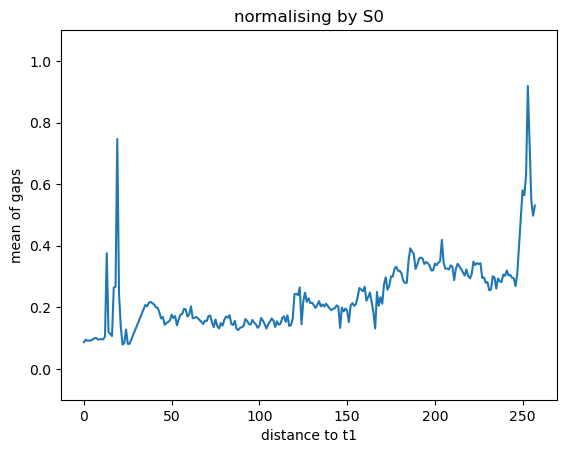

In [15]:
plt.plot(df_gap_S0.mean())
plt.xlabel('distance to t1')
plt.ylabel('mean of gaps')
plt.title('normalising by S0')
plt.ylim(-0.1, 1.1)

(-0.1, 1.1)

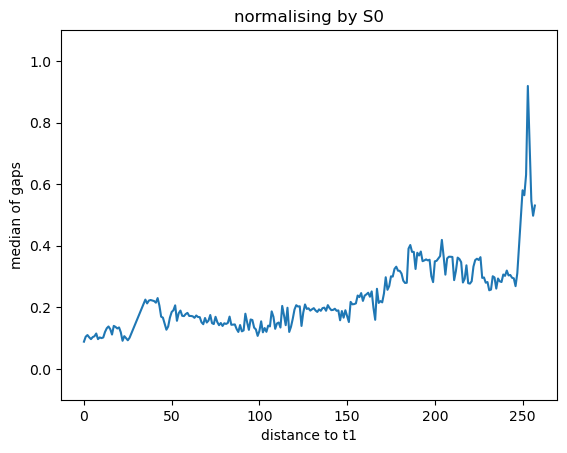

In [16]:
plt.plot(df_gap_S0.median())
plt.xlabel('distance to t1')
plt.ylabel('median of gaps')
plt.title('normalising by S0')
plt.ylim(-0.1, 1.1)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

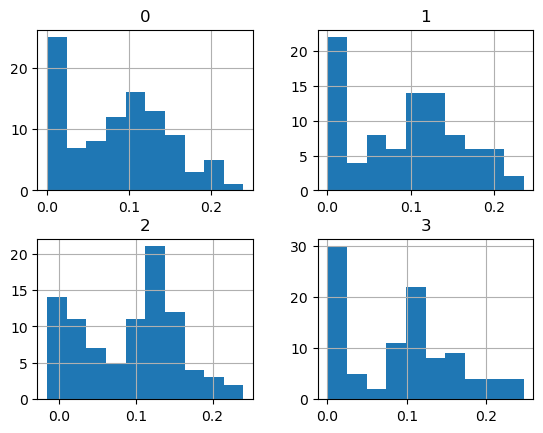

In [17]:
df_gap_S0[[0, 1, 2, 3]].hist()

array([[<Axes: title={'center': '40'}>, <Axes: title={'center': '41'}>],
       [<Axes: title={'center': '42'}>, <Axes: title={'center': '43'}>]],
      dtype=object)

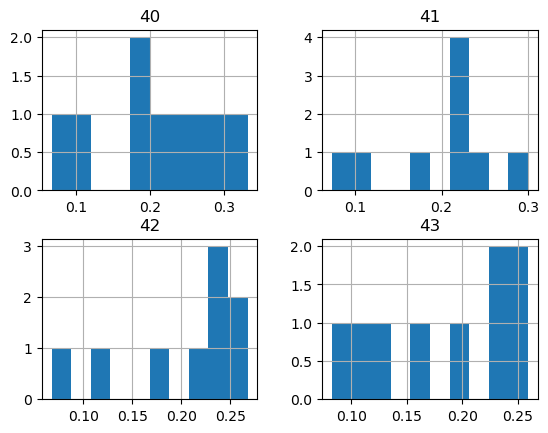

In [18]:
df_gap_S0[[40, 41, 42, 43]].hist()

array([[<Axes: title={'center': '13'}>, <Axes: title={'center': '19'}>]],
      dtype=object)

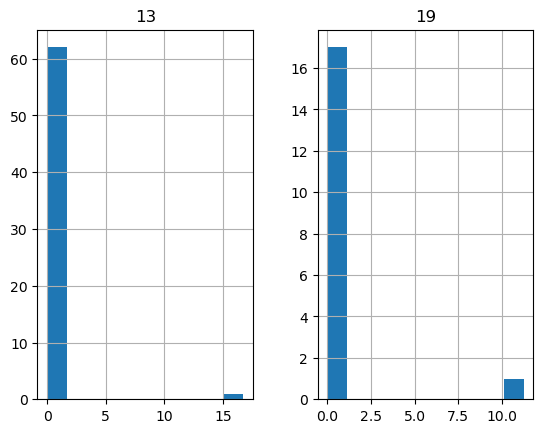

In [19]:
df_gap_S0[[13, 19]].hist()  # kind of outliers

(0.6, 1.05)

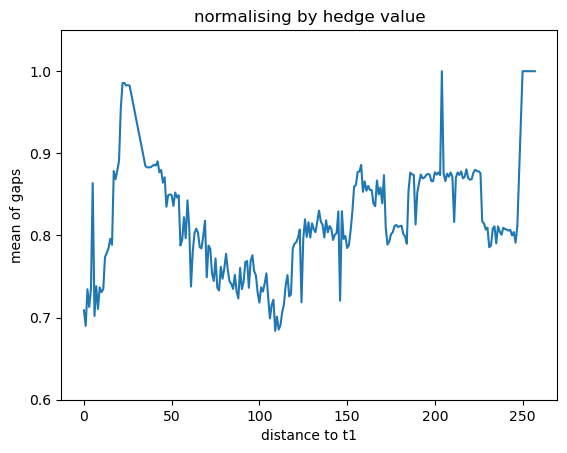

In [20]:
plt.plot(df_gap_hedge.mean())
plt.xlabel('distance to t1')
plt.ylabel('mean of gaps')
plt.title('normalising by hedge value')
plt.ylim(0.6, 1.05)

(0.6, 1.05)

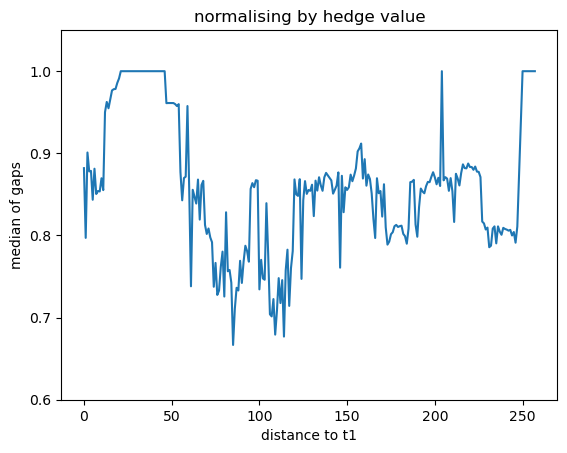

In [21]:
plt.plot(df_gap_hedge.median())
plt.xlabel('distance to t1')
plt.ylabel('median of gaps')
plt.title('normalising by hedge value')
plt.ylim(0.6, 1.05)

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>]],
      dtype=object)

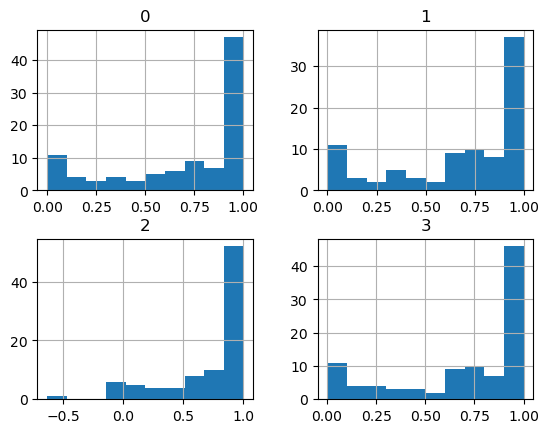

In [22]:
df_gap_hedge[[0, 1, 2, 3]].hist()

array([[<Axes: title={'center': '40'}>, <Axes: title={'center': '41'}>],
       [<Axes: title={'center': '42'}>, <Axes: title={'center': '43'}>]],
      dtype=object)

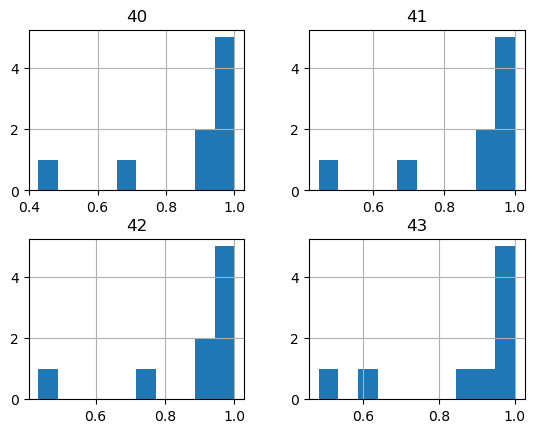

In [23]:
df_gap_hedge[[40, 41, 42, 43]].hist()

In [24]:
df_gap_S0.to_csv('gap_1MonthT1T2_S0.csv')
df_gap_hedge.to_csv('gap_1MonthT1T2_hedge.csv')